In [1416]:
# Packages:
import pandas as pd
import numpy as np
from datetime import date
import re # split, sub Befehle - string-character entfernen

#import random
#import csv
#import sys
#import math
from collections import Counter # Zählen von Duplikaten
import pathlib
import collections
import xml.etree.ElementTree as ET # Parsing Prozess durch (inline)-XBRL-Instanz


##### für die Grafik Standardnormalverteilung:
# Import all libraries for this portion of the blog post
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Multiple Regression
from sklearn.linear_model import LinearRegression

### Verbindung zu MS-SQL-Server
import pyodbc
import urllib

# Alle Funktionen: 

In [1417]:
# Funktion die die Posten darauf prüft, ob diese negativ = 0 bzw. positiv bzw. gleich 0 sind = 1
def check_if_negativ(posten):
    if posten < 0:
        return 0
    else:
        return 1
    
# Standardnormalverteilung
def normalProbabilityDensity(x):
    constant = 1.0 / np.sqrt(2*np.pi)
    return(constant * np.exp((-x**2) / 2.0) )
# Berechnung des Integrals um die kumulative Standardnormalverteilung zu berechnen, mit mü: 0 und Stdabw: 1

# Parsing von Elementen ohne Datum - insbesondere für EntityPublicFloat relevant
# EntityPublicFloat = Marktwert Eigenkapital = Outstanding Shares * current value shares as reporting date

def parsing_wo_date(Suchbegriffe, direction):
    tree_def = ET.parse(direction) 

# Funktion um den Marktkapitlisierungswert in XBRL-Dokument zu finden
# Suchbegriff = "EntityPublicFloat"
    searched=[]
    for element in tree_def.iter():
        for Suchbegriff in Suchbegriffe:
            if Suchbegriff == element.tag.split("}", 1)[1]:
                tag_name = element.tag.split("}", 1)[1]
                tag_value = element.text

                searched.append(tag_name)
                searched.append(int(tag_value))

                return searched

# Parsing-Funktion 

# Eingabe des Dateipfads, der Taxnomomie, und der gesuchten Stichtage
def xml_sec_parsing(direction, tax_dir, Jahr_Anfang, VJ_Anfang, VJ_Stichtag, Jahr_Stichtag):
    
    tree_def = ET.parse(direction) # Parsing initialisieren 


    ##############################################################
    x=-1
    context_index=[] # Index-Nummer wo Index in XML-Instanz zu finden ist - wie vielte Tag?
    context_id=[] # enthält den Inhalt des Context-Tag
    instant_index=[]
    instant_id=[]
    startDate_id=[]
    startDate_index=[]
    endDate_id=[]
    endDate_index=[]
    explicitMember_index=[]
    explicitMember_id=[]

    # Finden von Element.tags mit den tags context, instant, startDate, endDate

    for element in tree_def.iter(): # xsd
        x=x+1
        if "context" in element.tag:
            context_id.append(element.attrib.values()) # speichert Inhalt von Context-Tag
            context_index.append(x) # speichert Index-Nummer von Context-Tag
            # nach Context-Tag kommt immer entweder: instant (Stichtag) oder startDate und endDate (periodenbezogen)
            # also die nachfolgende Tags untersuchen, ob instant oder start- endDate haben und Inhalte speichern
        elif "instant" in element.tag: # instant-Werte = Stichtagsbezogene Werte
            instant_id.append(element.text)
            instant_index.append(x)
        elif "startDate" in element.tag: # duration-Werte = periodenbezogene Werte
            startDate_id.append(element.text)
            startDate_index.append(x)
        elif "endDate" in element.tag: # duration-Werte = periodenbezogene Werte
            endDate_id.append(element.text)
            endDate_index.append(x)  
        elif "explicitMember" in element.tag: # prüfe ob explicitMember enthalten ist - 
            # denn diese contextRefs brauche ich nicht
            # enthält meist Axis Daten - also Teile von Aggregationen 
            explicitMember_id.append(element.attrib)
            explicitMember_index.append(x)

            #print(element.attrib) 


    ##################################################        

    # alle Index-Werte in eine Liste zusammenfügen
    full_index=context_index.copy()
    full_index.extend(instant_index)
    full_index.extend(startDate_index)
    full_index.extend(endDate_index)

    #Erweiterung um explicitMember-Index-Werte
    full_index.extend(explicitMember_index)



    ############################################

    # erzeugen von 5 DataFrames, mit Context, Instant-Date, startdate und enddate
    # jedes DataFrame enthält Inhalt von XML, Index-Nr von XML und 
    # # jeweils Index-Bezeichnung: z.B. context, instant, enddate, startDate

    df_context = pd.DataFrame(context_index, context_id,  columns=["id"]).reset_index()
    df_instant = pd.DataFrame(instant_index, instant_id, columns=["id"]).reset_index()
    df_startDate = pd.DataFrame(startDate_index, startDate_id, columns=["id"]).reset_index()
    df_endDate = pd.DataFrame(endDate_index, endDate_id, columns=["id"]).reset_index()
    # explicitMember
    df_explicitMember = pd.DataFrame(explicitMember_index, explicitMember_id, columns=["id"]).reset_index()


    # jeder Dataframe bekommt auf jeder Zeile den Namen des Tags zugewiesen
    df_context["name"]=["context"]*len(context_index)
    df_instant["name"]=["instant"]*len(instant_index)
    df_startDate["name"]=["startDate"]*len(startDate_index)
    df_endDate["name"]=["endDate"]*len(endDate_index)
    #explicit Member
    df_explicitMember["name"]=["explicitMember"]*len(explicitMember_index)

    # Zusammenfügen aller Dataframes
    frames = [df_context, df_instant, df_startDate, df_endDate, df_explicitMember]
    result = pd.concat(frames)


    result_sorted=result.sort_values(by=['id']) # Sortieren nach id

    # pivot = reshape des Datframe
    result_sorted_pivot=result_sorted.pivot(index="id", columns="name", values="index")
    # dadurch folgenden Ausgabe:
    # name	context	                                     endDate	instant	startDate
    # 4069	(eol_PE89370---1410-K0012_STD_92_20110930_0)	NaN	      NaN	   NaN
    # 4073	NaN	                                             NaN	NaN	    2011-07-01
    # 4074	NaN	                                         2011-09-30	 NaN	  NaN


    context_column_only_df=result_sorted_pivot["context"]

    # befülle alle nachfolgenden Spaltenwerte mit NaN mit vorherigen context-Inhalt
    # forward-fill
    # befüllt nachfolgende NaN-Werte mit vorherigen context-Inhalt
    context_column_only_df_fill=context_column_only_df.fillna(method='ffill') 

    # befülle die vollständigen context-Inhalte in den DataFrame
    result_sorted_pivot["context"]=context_column_only_df_fill
    # jetzt keine NaN-Werte mehr vorhanden


    # groupby-Funktion - Ziel: noch sind die Daten auf mehreren Zeilen verteilt
    # z.B. startDate und endDate hat zwar jeweils gleiche context-id 
    # aber stehen auf unterschiedlichen Zeilen
    # damit stehen diese nun auf derselben Zeile
    # bei Alere Inc aus ca. 1900 --> 732 Zeilen beschränkt

    ############################################################################################
    # Ziel aus dict_values(['eol_PE89370---1410-K0012_STD_91_20140630_0']) 
    # --> wird 'eol_PE89370---1410-K0012_STD_91_20140630_0'
    # 
    ohne_dict_values=[]
    for i in range(0, len(result_sorted_pivot)):
        ohne=str(result_sorted_pivot.iloc[i,0]).split('[', 1)[1].split(']')[0].replace("'", "")
        ohne_dict_values.append(ohne)



    result_sorted_pivot["context"]=ohne_dict_values

    aggregation_functions = {'endDate': 'first', 'instant': 'first', 'startDate': 'first', "explicitMember":'first'}
    result_sorted_all_only_ones=result_sorted_pivot.groupby(['context']).aggregate(aggregation_functions)

    result_sorted_all_only_ones=result_sorted_all_only_ones.fillna(0)


    # neu dazu, um nur relevantes zu behalten
    ### Behalte nur jene context-Ref Daten, wo keine Dimensionsdaten in Spalte explicitMember enthalten sind
    context_result=[]
    for i in range(0, len(result_sorted_all_only_ones)):
        if isinstance(result_sorted_all_only_ones["explicitMember"][i], int):
            a=result_sorted_all_only_ones.iloc[i,:]
            context_result.append(a)

            # Anzahl stark reduziert und jetzt in ein DataFrame umwandeln - schaut gut aus
    result_sorted_all_only_ones=pd.DataFrame(context_result)

    # bei Alere Inc: 18 Ergebnisse - Durchsicht zeigt es gibt nur 4 contextRefs 
    # die den gesuchten Zeitraum angeben - es dürfte funktioniert haben :)


    ####################################################################################################


    ### Gesamtabfrage in einer Zeile Code in einer Variable gespeichert statt in 4 Variablen!!!! 
    # zum Beispiel:
    # Werte in Periodenzeitraum: 1.1.2014 bis 31.12.2014
    #Jahr_Anfang="2014-01-01"
    # Werte in Periodenzeitraum: 1.1.2013 bis 31.12.2013
    #VJ_Anfang="2013-01-01"
    # Filterung Stichtag Vorjahr
    #VJ_Stichtag="2013-12-31"
    #Filterung Stichtag des Jahresabschluss (dieses Jahr)
    #Jahr_Stichtag="2014-12-31"

    context_ids=result_sorted_all_only_ones[(result_sorted_all_only_ones["instant"].str.contains(Jahr_Stichtag, na=False)) | \
        (result_sorted_all_only_ones["instant"].str.contains(VJ_Stichtag, na=False)) | \
            (result_sorted_all_only_ones["startDate"].str.contains(Jahr_Anfang, na=False)) & \
                (result_sorted_all_only_ones["endDate"].str.contains(Jahr_Stichtag, na=False)) | \
                    (result_sorted_all_only_ones["startDate"].str.contains(VJ_Anfang, na=False)) & \
                        (result_sorted_all_only_ones["endDate"].str.contains(VJ_Stichtag, na=False))]

    ##########################################################################################

    # Abspeichern der Attribut-Inhalte und Values die im XML-File enthalten sind - 
    # nur jene Posten inkludiert, die auch im SEC-Taxonomie File enthalten sind

    name_attribut=[] # speichert Attribut-Inhalte von context
    name_value=[] # speichert Werte
    tag_names=[] # speichert tag-namen
    posten_arten=[] # speichert die Postenarten z.B. revenues_TOP, (also eigene Bezeichnungen zu tag-names)
    for element in tree_def.iter():
        for tax_element in range(0, len(tax_dir_np)):
            # Abgleich mit in --> nicht gut geeignet, da es nur nach Ähnlichkeiten sucht --> daher == zu verwenden
            if tax_dir_np[tax_element,2] == str(element.tag.split("}", 1)[1]): #suche Taxonomie Element aus Excel file in XBRL-Instanz
                #Zwischenspeichern der Inhalte
                tags=element.tag.split("}", 1)[1] # splitten des Tags - nur Tag-Name übernehmen, Rest fällt weg
                name=element.attrib # Speichere Attribut-Inhalt von Tag in eigener Liste
                value=element.text
                
                # Posten_Art aus tax_dir-File noch hinzufügen
                posten_art=tax_dir_np[tax_element, 0]
                

                # befüllen der Listen
                tag_names.append(tags)
                name_attribut.append(name)
                name_value.append(value)
                posten_arten.append(posten_art)

    # In die Liste mit jeweils einem Dict an jeder Stelle - neue Keys einfügen, in denen die Tag-Names und die Values enthalten sind
    for i in range(0, len(name_attribut)):
        name_attribut[i]["value"]=name_value[i] # jeder Value aus Liste name_value wird in name_attribut eingefügt
        name_attribut[i]["tag_name"]=tag_names[i]
        name_attribut[i]["Posten_Art"]=posten_arten[i]

    ########################################################################################################################

    # Herausfiltern jener name_attribut Elemente, die context_Ref (also Zeitraum betreffen) der unrelevant ist
    # für Alere Inc z.B. nur 1.1.2013 - 31.12.2013, 1.1.2014 - 31.12.2014, 31.12.2014 und 31.12.2013 relevant
    # Rest ist überflüssig und wird nachfolgend herausgefiltert

    instants=[] # speichern der instant-Daten
    endDates=[] # speichern der endDate-Daten
    startDates=[] # speichern der startDate-Daten

    relevante_attribute=[]
    for i in range(0, len(name_attribut)): # jeden contextRef durchiterieren in XBRL-Instanz
        for j in range(0, len(context_ids)): # jeden contextRef durchiterieren mit relevanten ids. 
            # prüfe, wenn id aus XBRL-Instanz relevant ist dann:
            if name_attribut[i].get('contextRef') == context_ids.index[j]:
                rel=name_attribut[i]
                ### speichern von Instant, startDate und endDate
                instant_date=context_ids["instant"][j]
                endDate=context_ids["endDate"][j]
                startDate=context_ids["startDate"][j]
                instants.append(instant_date)
                endDates.append(endDate)
                startDates.append(startDate)
                relevante_attribute.append(rel)

    for i in range(0, len(relevante_attribute)):
        relevante_attribute[i]["instant"]=instants[i] # jeder Value aus Liste name_value wird in name_attribut eingefügt
        relevante_attribute[i]["endDate"]=endDates[i]
        relevante_attribute[i]["startDate"]=startDates[i]

    df_result=pd.DataFrame(relevante_attribute)
    
    return relevante_attribute


############################################################
# Funktion das importierte Excel-Taxonomie-File durchsucht. 
# Wenn ein Taxonomie-Element im XBRL-File mit dem der Taxonomie übereinstimmt, 
# dann wird der dazugehörige Wert der Variable zugewiesen


### Funktion, der die stufe_2 Liste erzeugt, in der alle "Stufe_2" Posten enthalten sind
# taxonomy_file --> importierte Excel Datei = DataFrame mit alle zu suchenden Tag_names
# Suchbegriff --> Posten_Art die gesucht wird (--> selbst definierte Kategorie) z.B. "revenues"


def stufe_2_liste_erzeugen(taxonomy_file, Suchbegriff):
    stufe_2_liste=[] # leere Liste
    
    # Iteration durch das Taxonomy-File --> so dass jeder Tag-name einzeln hinzugefügt wird
    # und nicht mehr als gesamter Block 
    for i in range(0, len(taxonomy_file[taxonomy_file["Posten_Art"] == Suchbegriff])):
        a = taxonomy_file[taxonomy_file["Posten_Art"] == Suchbegriff].iloc[i,2]
    
        # Zuweisung der tag-Names in eine Liste
        stufe_2_liste.append(a)
    
    return stufe_2_liste


def kombo_posten_zuweisung_duration_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    try:
        return posten_zuweisung_stufenweise_duration_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)
    except:
        return posten_zuweisung_stufenweise_duration_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)
    


##################################################################################
# Funktion vom 26.04.2022 - Zweck: Abfangen von Fehlern, wenn kein Treffer bei duration-Werten zu finden sind
# Wurde aufgrund zu häufiger Fehlermeldungen später vereinfacht und ist nicht angewendet worden im finalen Code


# Version vom 26.04.2022 --> neu: If-Statements nach Try, um Fehler abzufangen, wenn kein Treffer zu finden ist
# nur für Fehlermeldungen verwendbar, wenn es einen Posten nicht gibt

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # nur wenn es einen Treffer gibt, dann wird es in ein Integer umgewandelt
        if len(company_file[(company_file["tag_name"] == stufe_1) & (company_file["endDate"].str.contains(Datum_Jahr, case=False))]) > 0:
            
            step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        else:
            step_1_value_J = 0
        # Vorjahres-Ergebnisse
        
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        #stufe_1_liste.append(step_1_value_VJ)
        

        return stufe_1_liste
        
    except TypeError: 
        
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    #step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    #stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
        
            
        return stufe_2_liste

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, 
# aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # diesjähriges Ergebnis
        step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # Vorjahres-Ergebnisse
        #step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
       # stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    #step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                   # stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
                    
            
        return stufe_2_liste
            
def kombo_posten_zuweisung_duration(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    try:
        return posten_zuweisung_stufenweise_duration(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr)
    except:
        return posten_zuweisung_stufenweise_duration_ERROR(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr)

# Version vom 26.04.2022 --> neu: If-Statements nach Try, um Fehler abzufangen, wenn kein Treffer zu finden ist
# nur für Fehlermeldungen verwendbar, wenn es einen Posten nicht gibt


##################################################################################
# Funktion vom 26.04.2022 - Zweck: Abfangen von Fehlern, wenn kein Treffer bei duration-Werten zu finden sind
# Wurde aufgrund zu häufiger Fehlermeldungen später vereinfacht und ist nicht angewendet worden im finalen Code


# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration_ERROR(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # nur wenn es einen Treffer gibt, dann wird es in ein Integer umgewandelt
        if len(company_file[(company_file["tag_name"] == stufe_1) & (company_file["endDate"].str.contains(Datum_Jahr, case=False))]) > 0:
            
            step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        else:
            step_1_value_J = 0
        # Vorjahres-Ergebnisse
        
        if len(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]) > 0:
            step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
        
        else:
            step_1_value_VJ = 0
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        

        return stufe_1_liste
        
    except TypeError: 
        
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        # neu
        if len(stufe_2_liste) == 1: # wenn nur ein Wert für ein Jahr vorhanden ist - füge einmal eine Null hinzu
            stufe_2_liste.append(0)
        
        elif len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
        
            
        return stufe_2_liste

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, 
# aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # diesjähriges Ergebnis
        step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # Vorjahres-Ergebnisse
        step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        # neu
        if len(stufe_2_liste) == 1: # wenn nur ein Wert für ein Jahr vorhanden ist - füge einmal eine Null hinzu
            stufe_2_liste.append(0)
        
        elif len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
                    
            
        return stufe_2_liste
            
        
def kombo_posten_zuweisung_instant_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    try:
        return posten_zuweisung_stufenweise_instant_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)
    except:
        return posten_zuweisung_stufenweise_instant_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)

# Version vom 26.04.2022 --> neu: If-Statements nach Try, um Fehler abzufangen, wenn kein Treffer zu finden ist
# nur für Fehlermeldungen verwendbar, wenn es einen Posten nicht gibt

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_instant_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # nur wenn es einen Treffer gibt, dann wird es in ein Integer umgewandelt
        if len(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Jahr, case=False))]) > 0:
            
            # am Ende [0] - also nehme nur ersten Wert
            step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        else:
            step_1_value_J = 0
        # Vorjahres-Ergebnisse
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        # stufe_1_liste.append(step_1_value_VJ)
        

        return stufe_1_liste
        
    except TypeError: 
        
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    # step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]

                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    #stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1: # wenn überhaupt kein Treffer vorhanden ist - füge Nuller ein
            stufe_2_liste.append(0)
   
            
        return stufe_2_liste


# #######################################################################################################
# Vereinfachte Funktion zur Feststellung der gesuchten Werte 
# Feststellung aller stichtagsbezogenen Werte im XBRL-Dokument
# #######################################################################################################


# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_instant_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # am Ende [0] - also nehme nur ersten Wert
        # diesjähriges Ergebnis
        step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # am Ende [0] - also nehme nur ersten Wert
        # Vorjahres-Ergebnisse
        #step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) &
        #  (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        #stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2: # Iteration durch stufe_2 liste
            # set von company_file - da Postennamen stets mind. 2x vorhanden sind
            # einmal Jahr z.B. 2014 und einmal 2013 
            # ohne set würde es den Postennamen 2x nehmen und ich habe die Werte 4x ausgegeben 
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    #step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    #stufe_2_liste.append(step_2_value_VJ)
                    
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)

            
        return stufe_2_liste

    
# ohne tax_dir
def xml_parsing_all_within_time_range(direction, Jahr_Anfang, VJ_Anfang, VJ_Stichtag, Jahr_Stichtag):
    
    # Iteration durch XBRL-Instanz 
    tree_def = ET.parse(direction) # Parsing initialisieren 


    ##############################################################
    x=-1
    context_index=[] # Index-Nummer wo Index in XML-Instanz zu finden ist - wie vielte Tag?
    context_id=[] # enthält den Inhalt des Context-Tag
    instant_index=[]
    instant_id=[]
    startDate_id=[]
    startDate_index=[]
    endDate_id=[]
    endDate_index=[]
    explicitMember_index=[]
    explicitMember_id=[]

    for element in tree_def.iter(): # xsd
        x=x+1
        if "context" in element.tag:
            context_id.append(element.attrib.values()) # speichert Inhalt von Context-Tag
            context_index.append(x) # speichert Index-Nummer von Context-Tag
            # nach Context-Tag kommt immer entweder: instant (Stichtag) oder startDate und endDate (periodenbezogen)
            # also die nachfolgende Tags untersuchen, ob instant oder start- endDate haben und Inhalte speichern
        elif "instant" in element.tag:
            instant_id.append(element.text)
            instant_index.append(x)
        elif "startDate" in element.tag:
            startDate_id.append(element.text)
            startDate_index.append(x)
        elif "endDate" in element.tag:
            endDate_id.append(element.text)
            endDate_index.append(x)  
        elif "explicitMember" in element.tag: # prüfe ob explicitMember enthalten ist - denn diese contextRefs brauche ich nicht
            # enthält meist Axis Daten - also Teile von Aggregationen 
            explicitMember_id.append(element.attrib)
            explicitMember_index.append(x)

            #print(element.attrib) 


    ##################################################        

    # alle Index-Werte in eine Liste zusammenfügen
    full_index=context_index.copy()
    full_index.extend(instant_index)
    full_index.extend(startDate_index)
    full_index.extend(endDate_index)

    #Erweiterung um explicitMember-Index-Werte
    full_index.extend(explicitMember_index)



    ############################################

    # erzeugen von 5 DataFrames, mit Context, Instant-Date, startdate und enddate
    # jedes DataFrame enthält Inhalt von XML, Index-Nr von XML und jeweils Index-Bezeichnung: z.B. context, instant, enddate, startDate

    df_context = pd.DataFrame(context_index, context_id,  columns=["id"]).reset_index()
    df_instant = pd.DataFrame(instant_index, instant_id, columns=["id"]).reset_index()
    df_startDate = pd.DataFrame(startDate_index, startDate_id, columns=["id"]).reset_index()
    df_endDate = pd.DataFrame(endDate_index, endDate_id, columns=["id"]).reset_index()
    # explicitMember
    df_explicitMember = pd.DataFrame(explicitMember_index, explicitMember_id, columns=["id"]).reset_index()


    # jeder Dataframe bekommt auf jeder Zeile den Namen des Tags zugewiesen
    df_context["name"]=["context"]*len(context_index)
    df_instant["name"]=["instant"]*len(instant_index)
    df_startDate["name"]=["startDate"]*len(startDate_index)
    df_endDate["name"]=["endDate"]*len(endDate_index)
    #explicit Member
    df_explicitMember["name"]=["explicitMember"]*len(explicitMember_index)

    # Zusammenfügen aller Dataframes
    frames = [df_context, df_instant, df_startDate, df_endDate, df_explicitMember]
    result = pd.concat(frames)


    result_sorted=result.sort_values(by=['id']) # Sortieren nach id

    # pivot = reshape des Datframe
    result_sorted_pivot=result_sorted.pivot(index="id", columns="name", values="index")
    # dadurch folgenden Ausgabe:
    # name	context	                                     endDate	instant	startDate
    # 4069	(eol_PE89370---1410-K0012_STD_92_20110930_0)	NaN	      NaN	   NaN
    # 4073	NaN	                                             NaN	NaN	    2011-07-01
    # 4074	NaN	                                         2011-09-30	 NaN	  NaN


    context_column_only_df=result_sorted_pivot["context"]

    # befülle alle nachfolgenden Spaltenwerte mit NaN mit vorherigen context-Inhalt
    # forward-fill
    # befüllt nachfolgende NaN-Werte mit vorherigen context-Inhalt
    context_column_only_df_fill=context_column_only_df.fillna(method='ffill') 

    # befülle die vollständigen context-Inhalte in den DataFrame
    result_sorted_pivot["context"]=context_column_only_df_fill
    # jetzt keine NaN-Werte mehr vorhanden


    # groupby-Funktion - Ziel: noch sind die Daten auf mehreren Zeilen verteilt
    # z.B. startDate und endDate hat zwar jeweils gleiche context-id 
    # aber stehen auf unterschiedlichen Zeilen
    # damit stehen diese nun auf derselben Zeile
    # bei Alere Inc aus ca. 1900 --> 732 Zeilen beschränkt

    ############################################################################################
    # Ziel aus dict_values(['eol_PE89370---1410-K0012_STD_91_20140630_0'])
    # wird 'eol_PE89370---1410-K0012_STD_91_20140630_0'
    # hoffentlich geht dann Fehlermeldung weg !!!!!!!!!

    ohne_dict_values=[]
    for i in range(0, len(result_sorted_pivot)):
        ohne=str(result_sorted_pivot.iloc[i,0]).split('[', 1)[1].split(']')[0].replace("'", "")
        ohne_dict_values.append(ohne)



    result_sorted_pivot["context"]=ohne_dict_values

    aggregation_functions = {'endDate': 'first', 'instant': 'first', 'startDate': 'first', "explicitMember":'first'}
    result_sorted_all_only_ones=result_sorted_pivot.groupby(['context']).aggregate(aggregation_functions)

    result_sorted_all_only_ones=result_sorted_all_only_ones.fillna(0)


    # neu dazu, um nur relevantes zu behalten
    ### Behalte nur jene context-Ref Daten, wo keine Dimensionsdaten in Spalte explicitMember enthalten sind
    context_result=[]
    for i in range(0, len(result_sorted_all_only_ones)):
        if isinstance(result_sorted_all_only_ones["explicitMember"][i], int):
            a=result_sorted_all_only_ones.iloc[i,:]
            context_result.append(a)

            # Anzahl stark reduziert und jetzt in ein DataFrame umwandeln - schaut gut aus
    result_sorted_all_only_ones=pd.DataFrame(context_result)

    # bei Alere Inc: 18 Ergebnisse - Durchsicht zeigt es gibt nur 
    # 4 contextRefs die den gesuchten Zeitraum angeben - es dürfte funktioniert haben :)


    ####################################################################################################


    ### Gesamtabfrage in einer Zeile Code in einer Variable gespeichert statt in 4 Variablen!!!! 
    # Werte in Periodenzeitraum: 1.1.2014 bis 31.12.2014
    #Jahr_Anfang="2014-01-01"
    # Werte in Periodenzeitraum: 1.1.2013 bis 31.12.2013
    #VJ_Anfang="2013-01-01"
    # Filterung Stichtag Vorjahr
    #VJ_Stichtag="2013-12-31"
    #Filterung Stichtag des Jahresabschluss (dieses Jahr)
    #Jahr_Stichtag="2014-12-31"

    context_ids=result_sorted_all_only_ones[(result_sorted_all_only_ones["instant"].str.contains(Jahr_Stichtag, na=False)) | \
        (result_sorted_all_only_ones["instant"].str.contains(VJ_Stichtag, na=False)) | \
            (result_sorted_all_only_ones["startDate"].str.contains(Jahr_Anfang, na=False)) & \
                (result_sorted_all_only_ones["endDate"].str.contains(Jahr_Stichtag, na=False)) | \
                    (result_sorted_all_only_ones["startDate"].str.contains(VJ_Anfang, na=False)) & \
                        (result_sorted_all_only_ones["endDate"].str.contains(VJ_Stichtag, na=False))]

    ##########################################################################################

    # Abspeichern der Attribut-Inhalte und Values die im XML-File enthalten sind - 
    # nur jene Posten inkludiert, die auch im SEC-Taxonomie File enthalten sind

    name_attribut=[] # speichert Attribut-Inhalte von context
    name_value=[] # speichert Werte
    tag_names=[] # speichert tag-namen
    posten_arten=[] # speichert die Postenarten z.B. revenues_TOP, (also eigene Bezeichnungen zu tag-names)
    
    # Iteration durch alle Elemente - keine Filterung über Taxonomie um sämtliche Tags zu erhalten
    for element in tree_def.iter():
        tags=element.tag.split("}", 1)[1] # splitten des Tags - nur Tag-Name übernehmen, Rest fällt weg
        name=element.attrib # Speichere Attribut-Inhalt von Tag in eigener Liste
        value=element.text

                # befüllen der Listen
        tag_names.append(tags)
        name_attribut.append(name)
        name_value.append(value)

    # In die Liste mit jeweils einem Dict an jeder Stelle - neue Keys einfügen, in denen die Tag-Names und die Values enthalten sind
    for i in range(0, len(name_attribut)):
        name_attribut[i]["value"]=name_value[i] # jeder Value aus Liste name_value wird in name_attribut eingefügt
        name_attribut[i]["tag_name"]=tag_names[i]
       # name_attribut[i]["Posten_Art"]=posten_arten[i]

    ########################################################################################################################

    # Herausfiltern jener name_attribut Elemente, die context_Ref (also Zeitraum Betreffen) der unrelevant ist

    # für Alere Inc z.B. nur 1.1.2013 - 31.12.2013, 1.1.2014 - 31.12.2014, 31.12.2014 und 31.12.2013 relevant

    # Rest ist überflüssig

    instants=[] # speichern der instant-Daten
    endDates=[] # speichern der endDate-Daten
    startDates=[] # speichern der startDate-Daten

    relevante_attribute=[]
    for i in range(0, len(name_attribut)): # jeden contextRef durchiterieren in XBRL-Instanz
        for j in range(0, len(context_ids)): # jeden contextRef durchiterieren mit relevanten ids. 
            # prüfe, wenn id aus XBRL-Instanz relevant ist dann:
            if name_attribut[i].get('contextRef') == context_ids.index[j]:
                rel=name_attribut[i]
                ### speichern von Instant, startDate und endDate
                instant_date=context_ids["instant"][j]
                endDate=context_ids["endDate"][j]
                startDate=context_ids["startDate"][j]
                instants.append(instant_date)
                endDates.append(endDate)
                startDates.append(startDate)
                relevante_attribute.append(rel)

    for i in range(0, len(relevante_attribute)):
        relevante_attribute[i]["instant"]=instants[i] # jeder Value aus Liste name_value wird in name_attribut eingefügt
        relevante_attribute[i]["endDate"]=endDates[i]
        relevante_attribute[i]["startDate"]=startDates[i]
        
    
    df_result=pd.DataFrame(relevante_attribute)
    
    # entfernen jener Rows, die nicht nummerische Werte in der Spalte "value" enthalten
    df_result = df_result[pd.to_numeric(df_result["value"], errors='coerce').notnull()]
    
    return df_result

### Funktion mit der die zwei DF vergleiche
### einmal DF gefiltert nach Zeitraum und andere DF gefiltert nach Zeitraum + Taxonomy
### so, dass nur jene erhalte, die nicht im Taxonomy + Zeitraum - File enthalten sind

# outer merge müsste funktionieren
def potential_missing_items(companyfile_df, all_df):
    a=all_df['tag_name'].isin(companyfile_df['tag_name'])
    not_matched=all_df[~a]
    
    return not_matched

### Funktion die Fehler abfängt - Versuche die Gleichung zu lösen, wenn nicht geht - gib als Ergebnis 0 aus
### insbesondere bei Divisionen sehr wichtig 
### wenn Zähler oder Nenner = 0 - ist Gesamtergebnis zwangsläufig 0
def versuche_losung(x):
    try:
        return x
    except:
        return 0
    
### Funktion mit der Error vermeide, wenn durch 0 dividiere
def no_zero_error(x,y):
    try:
        a=x/y
        return a
    except ZeroDivisionError:
        return 0
    
# Funktion mit der den Variable-Namen erhalte
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

#### Eingabe der Dateipfade zu den abgespeicherten XBRL-Dokumenten (lokal abgespeichert)

In [1407]:
### Eingabe des Pfads - wo die XML (XBRL-Instanz) liegt:
direction=r"C:\Users\Startklar\Documents\Master Data Science\Masterarbeit\esef\Jahresabschlüsse FRAUD\tangoe inc\31.12.2013F"
direction = direction.replace("\\", "/") # Verändere die Trennstriche, damit für Python der Pfad lesbar wird
direction = direction + "/tngo-20131231.xml"

### Eingabe des Pfads - wo die XML (XBRL-Instanz) liegt aus dem Vorjahr:
direction_34=r"C:\Users\Startklar\Documents\Master Data Science\Masterarbeit\esef\Jahresabschlüsse FRAUD\tangoe inc\31.12.2012R"
direction_34 = direction_34.replace("\\", "/") # Verändere die Trennstriche, damit für Python der Pfad lesbar wird
direction_34 = direction_34 + "/tngo-20121231.xml"


Prüfung welches Fiskaljahr im XBRL-Dokument ausgewiesen wird

In [1412]:
tree_def = ET.parse(direction) # Parsing initialisieren 
for element in tree_def.iter(): # xsd
    if "CurrentFiscalYearEndDate" in element.tag:
        print(element.attrib, element.text)
    #if "context" in element.tag:

{'id': 'Tag6', 'contextRef': 'D2013'} --12-31


Beispiel-Ausgabe welche element.tag in einem XBRL-Dokument enthalten sind

In [1413]:
tree_def = ET.parse(direction) 
for element in tree_def.iter():
    print(element.tag)

{http://www.xbrl.org/2003/instance}xbrl
{http://www.xbrl.org/2003/linkbase}schemaRef
{http://www.xbrl.org/2003/instance}context
{http://www.xbrl.org/2003/instance}entity
{http://www.xbrl.org/2003/instance}identifier
{http://www.xbrl.org/2003/instance}period
{http://www.xbrl.org/2003/instance}startDate
{http://www.xbrl.org/2003/instance}endDate
{http://www.xbrl.org/2003/instance}context
{http://www.xbrl.org/2003/instance}entity
{http://www.xbrl.org/2003/instance}identifier
{http://www.xbrl.org/2003/instance}period
{http://www.xbrl.org/2003/instance}instant
{http://www.xbrl.org/2003/instance}context
{http://www.xbrl.org/2003/instance}entity
{http://www.xbrl.org/2003/instance}identifier
{http://www.xbrl.org/2003/instance}segment
{http://xbrl.org/2006/xbrldi}explicitMember
{http://xbrl.org/2006/xbrldi}explicitMember
{http://www.xbrl.org/2003/instance}period
{http://www.xbrl.org/2003/instance}startDate
{http://www.xbrl.org/2003/instance}endDate
{http://www.xbrl.org/2003/instance}context
{ht

{http://fasb.org/us-gaap/2012-01-31}ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsRiskFreeInterestRateMaximum
{http://fasb.org/us-gaap/2012-01-31}SharebasedCompensationArrangementBySharebasedPaymentAwardFairValueAssumptionsExpectedTerm1
{http://fasb.org/us-gaap/2012-01-31}SharebasedCompensationArrangementBySharebasedPaymentAwardFairValueAssumptionsExpectedTerm1
{http://fasb.org/us-gaap/2012-01-31}SharebasedCompensationArrangementBySharebasedPaymentAwardFairValueAssumptionsExpectedTerm1
{http://fasb.org/us-gaap/2012-01-31}SharebasedCompensationArrangementBySharebasedPaymentAwardFairValueAssumptionsExpectedTerm1
{http://fasb.org/us-gaap/2012-01-31}SharebasedCompensationArrangementBySharebasedPaymentAwardFairValueAssumptionsExpectedTerm1
{http://fasb.org/us-gaap/2012-01-31}ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedVolatilityRateMinimum
{http://fasb.org/us-gaap/2012-01-31}ShareBasedCompensationArrangementByShareBased

Eingabe des lokalen Dateipfads 
zu dem abgespeicherten Excel-Taxonomie Dokument, 
indem die erlaubte Taxonomie der SEC enthalten ist
in diesem Excel-File sind nur monetäre tags enthalten, 
die für diese Arbeit relevant sind 

In [1348]:
# Eingabe von Dateipfad zu Excel-File, dass die gewünschten Element-Tags enthält:

tax_dir=r"C:\Users\Startklar\Documents\Master Data Science\Masterarbeit\esef"
tax_dir = tax_dir.replace("\\", "/") # Verändere die Trennstriche, damit für Python der Pfad lesbar wird
tax_dir = tax_dir + "/GAAP_taxonomy_2022_relevantes.xlsx"

# Import der Excel-Datei mit allen relevanten Element-Tag Namen, die für die Analyse benötigt werden
tax_dir = pd.read_excel (tax_dir, sheet_name='Modell_limitiert')

# Umwandeln des DataFrames in ein numpy-array für schnellere Filterung und Iterationen
tax_dir_np=tax_dir.to_numpy()
# len(tax_dir_np) - enthält zum Stand 20.04.2022: 85 Elemente
# tax_dir_np[0,2]: Ausgabe: "Revenues" - also 0 --> erste Zeile, 2 --> 3. Spalte


# Eingabe der Stichtage der Jahresabschlüsse 
# z.B. Unternehmen hat Stichtag 31.12.2014 - 
# Vorjahr 31.12.2013 - Vor-Vorjahr: 31.12.2021

In [1349]:
### Gesamtabfrage in einer Zeile Code in einer Variable gespeichert statt in 4 Variablen!!!! 
# Werte in Periodenzeitraum: 1.1.2013 bis 31.12.2013
VJ_Anfang="2012-01-01"
# Werte in Periodenzeitraum: 1.1.2014 bis 31.12.2014
Jahr_Anfang="2013-01-01"
# Filterung Stichtag Vorjahr
VJ_Stichtag="2012-12-31"
#Filterung Stichtag des Jahresabschluss (dieses Jahr)
Jahr_Stichtag="2013-12-31"

In [1350]:
### Gesamtabfrage in einer Zeile Code in einer Variable gespeichert statt in 4 Variablen!!!! 
# Werte in Periodenzeitraum: 1.1.2013 bis 31.12.2013
VJ_Anfang_34="2011-01-01"
# Werte in Periodenzeitraum: 1.1.2014 bis 31.12.2014
Jahr_Anfang_34="2012-01-01"
# Filterung Stichtag Vorjahr
VJ_Stichtag_34="2011-12-31"
#Filterung Stichtag des Jahresabschluss (dieses Jahr)
Jahr_Stichtag_34="2012-12-31"

In [1351]:
companyfile=xml_sec_parsing(direction, tax_dir, Jahr_Anfang, VJ_Anfang, VJ_Stichtag, Jahr_Stichtag)
companyfile_df=pd.DataFrame(companyfile)
companyfile_df = companyfile_df.fillna(0)

values_df=[]
for i in companyfile_df['value']:
    a=int(i)
    values_df.append(a)
companyfile_df['value'] = values_df

companyfile34=xml_sec_parsing(direction_34, tax_dir, Jahr_Anfang_34, VJ_Anfang_34, VJ_Stichtag_34, Jahr_Stichtag_34)
companyfile_df34=pd.DataFrame(companyfile34)
companyfile_df34 = companyfile_df34.fillna(0)

values_df=[]
for i in companyfile_df34['value']:
    a=int(i)
    values_df.append(a)
companyfile_df34['value'] = values_df

In [1415]:
companyfile_df

,id,decimals,contextRef,unitRef,value,tag_name,Posten_Art,instant,endDate,startDate
0,Tag43,-5,I2013,USD,43200000,CashEquivalentsAtCarryingValue,cash_and_cash_equivalents_TOP,2013-12-31,0,0
1,Tag166,-3,D2013,USD,189165000,BusinessAcquisitionsProFormaRevenue,revenues,0,2013-12-31,2013-01-01
2,Tag167,-3,D2012,USD,157627000,BusinessAcquisitionsProFormaRevenue,revenues,0,2012-12-31,2012-01-01
3,Tag186,-3,D2012,USD,3038000,NetIncomeLoss,net_income_loss,0,2012-12-31,2012-01-01
4,Tag187,-3,D2013,USD,4962000,NetIncomeLoss,net_income_loss,0,2013-12-31,2013-01-01
...,...,...,...,...,...,...,...,...,...,...
73,Tag1000,-3,D2012,USD,778000,ProceedsFromIssuanceOfDebt,change_LTD_borrow,0,2012-12-31,2012-01-01
74,Tag1011,-3,D2012,USD,30398000,NetCashProvidedByUsedInFinancingActivitiesCont...,cashflow_financing,0,2012-12-31,2012-01-01
75,Tag1012,-3,D2013,USD,-4735000,NetCashProvidedByUsedInFinancingActivitiesCont...,cashflow_financing,0,2013-12-31,2013-01-01
76,Tag1016,-3,D2012,USD,6804000,NetCashProvidedByUsedInContinuingOperations,change_cash,0,2012-12-31,2012-01-01


In [1352]:
all_df=xml_parsing_all_within_time_range(direction, Jahr_Anfang, VJ_Anfang, VJ_Stichtag, Jahr_Stichtag)
all_df = all_df.fillna(0)

missing=potential_missing_items(companyfile_df, all_df)

v = missing[missing["tag_name"].str.contains("netcash", case=False)]
# v[v["tag_name"].str.contains("", case=False)]
v

,id,contextRef,value,tag_name,instant,endDate,startDate,decimals,unitRef,{http://www.w3.org/2001/XMLSchema-instance}nil


In [1353]:
all_34_df=xml_parsing_all_within_time_range(direction_34, Jahr_Anfang_34, VJ_Anfang_34, VJ_Stichtag_34, Jahr_Stichtag_34)
all_34_df = all_34_df.fillna(0)


missing_34=potential_missing_items(companyfile_df34, all_34_df)

v1 = missing_34[missing_34["tag_name"].str.contains("increasedecrease", case=False)]
v1[v1["tag_name"].str.contains("payables", case=False)]

,id,decimals,contextRef,unitRef,value,tag_name,instant,endDate,startDate,{http://www.w3.org/2001/XMLSchema-instance}nil


In [1172]:
missing_34[missing_34["tag_name"].str.contains("netcash", case=False)]

,contextRef,decimals,id,unitRef,value,tag_name,instant,endDate,startDate,{http://www.w3.org/2001/XMLSchema-instance}nil


### Prüfen, ob gewisse Werte zu häufig bzw. zu selten vorkommen - Durchsicht auf potentielle Fehler
### Zumeist sollte eine gerade Anzahl an Ergebnissen folgen
### da Jahresabschluss meist nur Jahr und Vorjahr enthält

#### Jahr + Vorjahr

In [1014]:
a = dict(Counter(companyfile_df["Posten_Art"]))

for i in a:
    if int(a[i]) % 2 > 0: # Werte sollten immer nur paarweise ausgegeben werden (also Jahr und Vorjahr) 
        # resultiert ein Ergebnis das z.B. 1 mal vorkommt - dann wird diese Fehlermeldung ausgegeben
        print("Die Posten_Art", i, "ist ", a[i], "mal vorhanden")

Die Posten_Art LTD_LongTermDebt ist  3 mal vorhanden
Die Posten_Art change_LTD_payment ist  5 mal vorhanden


#### Vorjahr und Vor-Vor-Jahr (3 und 4)

In [923]:
a = dict(Counter(companyfile_df34["Posten_Art"]))

for i in a:
    if int(a[i]) % 2 > 0: # Werte sollten immer nur paarweise ausgegeben werden (also Jahr und Vorjahr) 
        # resultiert ein Ergebnis das z.B. mal vorkommt - dann wird diese Fehlermeldung ausgegeben
        print("Die Posten_Art", i, "ist ", a[i], "mal vorhanden")

Die Posten_Art revenues ist  3 mal vorhanden


#### Durchsuchen von DataFrame, wo möglicherweise ein Problem liegen könnte

In [726]:
potential_error="change_LTD_payment"
companyfile_df[companyfile_df["Posten_Art"].str.contains(potential_error, case=False)]

,decimals,contextRef,unitRef,value,tag_name,Posten_Art,instant,endDate,startDate


In [414]:
potential_error="revenues"
companyfile_df34[companyfile_df34["Posten_Art"].str.contains(potential_error, case=False)]

,id,contextRef,decimals,unitRef,value,tag_name,Posten_Art,instant,endDate,startDate


### Prüfen, ob die MUST-Variable-Tag-Names enthalten sind

# duration-Werte GuV (periodenbezogene Werte)
##  Jahr + Vorjahr
## Durchführung der Funktionen

In [1354]:
# kombo_posten_zuweisung_duration_one_year
##### ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd

stufe_1="Revenues" #tag-name den primär suche 
Suchbegriff="revenues"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# Zuweisung der Werte für Revenues in diesem und im Vorjahr
# Revenues_Jahr, Revenues_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
Revenues_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
Revenues_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="CashAndCashEquivalentsPeriodIncreaseDecrease" 
Suchbegriff="change_cash"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_cash_Jahr, change_cash_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
change_cash_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
change_cash_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="CostOfRevenue" 
Suchbegriff="cost_of_goods"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CostOfRevenue_Jahr, CostOfRevenue_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
CostOfRevenue_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
CostOfRevenue_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



stufe_1="Depreciation" 
Suchbegriff="depreciation_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# Depreciation_Jahr, Depreciation_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
Depreciation_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
Depreciation_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="DepreciationAndAmortization" 
Suchbegriff="depreciation_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# DepreciationAndAmortization_Jahr, DepreciationAndAmortization_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
DepreciationAndAmortization_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
DepreciationAndAmortization_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="GeneralAndAdministrativeExpense" 
Suchbegriff="general_administrative_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# GeneralAndAdministrativeExpense_Jahr, GeneralAndAdministrativeExpense_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
GeneralAndAdministrativeExpense_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
GeneralAndAdministrativeExpense_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments" 
Suchbegriff="earnings_before_taxes_EBT"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# EBT_Jahr, EBT_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)[0:2]
EBT_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
EBT_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



stufe_1="IncreaseDecreaseInAccountsPayable" 
Suchbegriff="change_acc_payables_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IncreaseDecreaseInAccountsPayable_Jahr, IncreaseDecreaseInAccountsPayable_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IncreaseDecreaseInAccountsPayable_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IncreaseDecreaseInAccountsPayable_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="IncreaseDecreaseInAccountsReceivable" 
Suchbegriff="change_receivables_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IncreaseDecreaseInAccountsReceivable_Jahr, IncreaseDecreaseInAccountsReceivable_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IncreaseDecreaseInAccountsReceivable_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IncreaseDecreaseInAccountsReceivable_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="IncreaseDecreaseInInventories" 
Suchbegriff="change_inventory"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IncreaseDecreaseInInventories_Jahr, IncreaseDecreaseInInventories_Vorjahr = 
#  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IncreaseDecreaseInInventories_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IncreaseDecreaseInInventories_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


#stufe_1="NetCashProvidedByUsedInOperatingActivitiesContinuingOperations" 
#Suchbegriff="change_current_assets_liabilities" # = Veränderung Working Capital
#stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
#WC_Jahr, WC_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="NetIncomeLoss" 
Suchbegriff="net_income_loss"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# NetIncomeLoss_Jahr, NetIncomeLoss_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
NetIncomeLoss_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
NetIncomeLoss_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="ProceedsFromIssuanceOfLongTermDebt" 
Suchbegriff="change_LTD_borrow"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_LTD_borrow_Jahr, change_LTD_borrow_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
change_LTD_borrow_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
change_LTD_borrow_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="RepaymentsOfLongTermDebt" 
Suchbegriff="change_LTD_payment"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_LTD_payment_Jahr, change_LTD_payment_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
change_LTD_payment_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
change_LTD_payment_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


# Cashflows Operativ, Investing und Financing:

stufe_1="NetCashProvidedByUsedInOperatingActivities" 
Suchbegriff="cashflow_operativ"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CF_operativ_Jahr, CF_operativ_Vorjahr = 
#  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
CF_operativ_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
CF_operativ_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="NetCashProvidedByUsedInInvestingActivities" 
Suchbegriff="cashflow_investing"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CF_investing_Jahr, CF_investing_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
CF_investing_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
CF_investing_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="NetCashProvidedByUsedInFinancingActivities" 
Suchbegriff="cashflow_financing"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CF_financing_Jahr, CF_financing_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
CF_financing_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
CF_financing_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


# deferred tax expenses für F Score Berechnung relevant
stufe_1="DeferredIncomeTaxExpenseBenefit" 
Suchbegriff="deferred_tax_expenses"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# deferred_tax_expense_Jahr, deferred_tax_expense_Vorjahr = 
#  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
deferred_tax_expense_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
deferred_tax_expense_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


# change income tax == deferred_tax_expense
# ist unter anderen Begriff bereits gesucht - daher findet der Code es unter change_income_tax_payables nicht
# daher bei change_income_tax_payables = deferred_tax_expense verwenden

# stufe_1="IncreaseDecreaseInIncomeTaxes" 
# Suchbegriff="change_income_tax_payables"
# stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_income_tax_Jahr, change_income_tax_Vorjahr = 
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)



### Zusätzliche Cashflow-Increase-Decrease Werte, um Working Capital zu berechnen
## ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd


### Summe aller change_acc_payables ermitteln --> alle "other" payables current
stufe_1="IncreaseDecreaseInNotesPayableCurrent" 
Suchbegriff="change_acc_payables_others"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDAccountsPayableOthers_Jahr, IDAccountsPayableOthers_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDAccountsPayableOthers_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDAccountsPayableOthers_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



stufe_1="IncreaseDecreaseInPrepaidDeferredExpenseAndOtherAssets" 
Suchbegriff="prepaid_exp_current_assets"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDPrepaidDeferredExpense_Jahr, IDPrepaidDeferredExpense_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDPrepaidDeferredExpense_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDPrepaidDeferredExpense_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="IncreaseDecreaseInAccruedLiabilitiesAndOtherOperatingLiabilities" 
Suchbegriff="accrued_exp_other_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDAccruedLiabilities_Jahr, IDAccruedLiabilities_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDAccruedLiabilities_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDAccruedLiabilities_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



stufe_1="IncreaseDecreaseInOtherOperatingLiabilities" 
Suchbegriff="other_non_current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDOtherOperatingLiab_Jahr, IDOtherOperatingLiab_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDOtherOperatingLiab_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDOtherOperatingLiab_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="BusinessCombinationContingentConsiderationArrangementsChangeInAmountOfContingentConsiderationAsset1" 
Suchbegriff="change_cash_paid_contingent_consideration"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDCashPaidContingent_Jahr, IDCashPaidContingent_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDCashPaidContingent_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDCashPaidContingent_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="IncreaseDecreaseInOtherCurrentAssets" 
Suchbegriff="change_other_current_assets"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDOtherCurrentAssets_Jahr, IDOtherCurrentAssets_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDOtherCurrentAssets_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDOtherCurrentAssets_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="IncreaseDecreaseInOtherCurrentAssetsAndLiabilitiesNet" 
Suchbegriff="change_other_current_assets_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDOtherCurrentAssetsLiab_Jahr, IDOtherCurrentAssetsLiab_Vorjahr = 
#  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDOtherCurrentAssetsLiab_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDOtherCurrentAssetsLiab_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="IncreaseDecreaseInDeferredRevenue" 
Suchbegriff="change_deferred_revenue"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDDeferredRevenue_Jahr, IDDeferredRevenue_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDDeferredRevenue_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDDeferredRevenue_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]

# komplexe Berechnung
# WC_Jahr = IncreaseDecreaseInAccountsPayable_Jahr + IncreaseDecreaseInAccountsReceivable_Jahr + 
# IncreaseDecreaseInInventories_Jahr + IDAccountsPayableOthers_Jahr + IDPrepaidDeferredExpense_Jahr +
#  IDAccruedLiabilities_Jahr + IDOtherOperatingLiab_Jahr + IDCashPaidContingent_Jahr + IDOtherCurrentAssets_Jahr + 
# IDOtherCurrentAssetsLiab_Jahr + IDDeferredRevenue_Jahr


# WC_Vorjahr = IncreaseDecreaseInAccountsPayable_Vorjahr + IncreaseDecreaseInAccountsReceivable_Vorjahr + 
# IncreaseDecreaseInInventories_Vorjahr + IDAccountsPayableOthers_Vorjahr + IDPrepaidDeferredExpense_Vorjahr + 
# IDAccruedLiabilities_Vorjahr + IDOtherOperatingLiab_Vorjahr + IDCashPaidContingent_Vorjahr + 
# IDOtherCurrentAssets_Vorjahr + IDOtherCurrentAssetsLiab_Vorjahr + IDDeferredRevenue_Vorjahr



# Other Payables zu den regulären Payables dazurechnen
IncreaseDecreaseInAccountsPayable_Jahr = IncreaseDecreaseInAccountsPayable_Jahr + IDAccountsPayableOthers_Jahr
IncreaseDecreaseInAccountsPayable_Vorjahr = IncreaseDecreaseInAccountsPayable_Vorjahr + IDAccountsPayableOthers_Vorjahr




## Vorjahr und Vor-Vorjahr periodenbezogene Werte - duration-Werte
## Durchführung der Funktionen

In [1355]:
stufe_1="Revenues" #tag-name den primär suche 
Suchbegriff="revenues"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# Zuweisung der Werte für Revenues in diesem und im Vorjahr
# Revenues_3, Revenues_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
Revenues_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
Revenues_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="CashAndCashEquivalentsPeriodIncreaseDecrease" 
Suchbegriff="change_cash"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_cash_3, change_cash_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
change_cash_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
change_cash_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="CostOfRevenue" 
Suchbegriff="cost_of_goods"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CostOfRevenue_3, CostOfRevenue_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
CostOfRevenue_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
CostOfRevenue_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="Depreciation" 
Suchbegriff="depreciation_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# Depreciation_3, Depreciation_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
Depreciation_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
Depreciation_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="DepreciationAndAmortization" 
Suchbegriff="depreciation_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# DepreciationAndAmortization_3, DepreciationAndAmortization_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
DepreciationAndAmortization_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
DepreciationAndAmortization_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="GeneralAndAdministrativeExpense" 
Suchbegriff="general_administrative_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# GeneralAndAdministrativeExpense_3, GeneralAndAdministrativeExpense_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
GeneralAndAdministrativeExpense_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
GeneralAndAdministrativeExpense_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments" 
Suchbegriff="earnings_before_taxes_EBT"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# EBT_3, EBT_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)[0:2]
EBT_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
EBT_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncreaseDecreaseInAccountsPayable" 
Suchbegriff="change_acc_payables_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IncreaseDecreaseInAccountsPayable_3, IncreaseDecreaseInAccountsPayable_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IncreaseDecreaseInAccountsPayable_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IncreaseDecreaseInAccountsPayable_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncreaseDecreaseInAccountsReceivable" 
Suchbegriff="change_receivables_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IncreaseDecreaseInAccountsReceivable_3, IncreaseDecreaseInAccountsReceivable_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IncreaseDecreaseInAccountsReceivable_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IncreaseDecreaseInAccountsReceivable_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncreaseDecreaseInInventories" 
Suchbegriff="change_inventory"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IncreaseDecreaseInInventories_3, IncreaseDecreaseInInventories_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IncreaseDecreaseInInventories_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IncreaseDecreaseInInventories_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

#stufe_1="NetCashProvidedByUsedInOperatingActivitiesContinuingOperations" 
#Suchbegriff="change_current_assets_liabilities" # = Veränderung Working Capital
#stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
#WC_3, WC_4 =  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)

stufe_1="NetIncomeLoss" 
Suchbegriff="net_income_loss"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# NetIncomeLoss_3, NetIncomeLoss_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
NetIncomeLoss_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
NetIncomeLoss_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="ProceedsFromIssuanceOfLongTermDebt" 
Suchbegriff="change_LTD_borrow"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_LTD_borrow_3, change_LTD_borrow_4 =  
# posten_zuweisung_stufenweise_duration_ERROR(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
change_LTD_borrow_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
change_LTD_borrow_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="RepaymentsOfLongTermDebt" 
Suchbegriff="change_LTD_payment"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_LTD_payment_3, change_LTD_payment_4 =  
# posten_zuweisung_stufenweise_duration_ERROR(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
change_LTD_payment_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
change_LTD_payment_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


# Cashflows Operativ, Investing und Financing:

stufe_1="NetCashProvidedByUsedInOperatingActivities" 
Suchbegriff="cashflow_operativ"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CF_operativ_3, CF_operativ_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
CF_operativ_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
CF_operativ_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="NetCashProvidedByUsedInInvestingActivities" 
Suchbegriff="cashflow_investing"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CF_investing_3, CF_investing_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
CF_investing_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
CF_investing_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="NetCashProvidedByUsedInFinancingActivities" 
Suchbegriff="cashflow_financing"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CF_financing_3, CF_financing_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
CF_financing_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
CF_financing_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


# change income tax = deferred_tax_expense
#stufe_1="IncreaseDecreaseInIncomeTaxes" 
#Suchbegriff="change_income_tax_payables"
#stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
#change_income_tax_3, change_income_tax_4 = 
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)

# deferred tax expenses für F Score Berechnung relevant
# deferred_tax_expenses = change in income tax expenses = change_income_tax_payables
stufe_1="DeferredIncomeTaxExpenseBenefit" 
Suchbegriff="deferred_tax_expense"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# deferred_tax_expense_3, deferred_tax_expense_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
deferred_tax_expense_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
deferred_tax_expense_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


### Zusätzliche Cashflow-Increase-Decrease Werte, um Working Capital zu berechnen

### Summe aller change_acc_payables ermitteln --> alle "other" payables current
stufe_1="IncreaseDecreaseInNotesPayableCurrent" 
Suchbegriff="change_acc_payables_others"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDAccountsPayableOthers_3, IDAccountsPayableOthers_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDAccountsPayableOthers_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDAccountsPayableOthers_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncreaseDecreaseInPrepaidDeferredExpenseAndOtherAssets" 
Suchbegriff="prepaid_exp_current_assets"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDPrepaidDeferredExpense_3, IDPrepaidDeferredExpense_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDPrepaidDeferredExpense_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDPrepaidDeferredExpense_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncreaseDecreaseInAccruedLiabilitiesAndOtherOperatingLiabilities" 
Suchbegriff="accrued_exp_other_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDAccruedLiabilities_3, IDAccruedLiabilities_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDAccruedLiabilities_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDAccruedLiabilities_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncreaseDecreaseInOtherOperatingLiabilities" 
Suchbegriff="other_non_current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDOtherOperatingLiab_3, IDOtherOperatingLiab_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDOtherOperatingLiab_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDOtherOperatingLiab_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="BusinessCombinationContingentConsiderationArrangementsChangeInAmountOfContingentConsiderationAsset1" 
Suchbegriff="change_cash_paid_contingent_consideration"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDCashPaidContingent_3, IDCashPaidContingent_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDCashPaidContingent_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDCashPaidContingent_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

stufe_1="IncreaseDecreaseInOtherCurrentAssets" 
Suchbegriff="change_other_current_assets"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDOtherCurrentAssets_3, IDOtherCurrentAssets_4 = 
#  posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDOtherCurrentAssets_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDOtherCurrentAssets_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="IncreaseDecreaseInOtherCurrentAssetsAndLiabilitiesNet" 
Suchbegriff="change_other_current_assets_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDOtherCurrentAssetsLiab_3, IDOtherCurrentAssetsLiab_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDOtherCurrentAssetsLiab_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDOtherCurrentAssetsLiab_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="IncreaseDecreaseInDeferredRevenue" 
Suchbegriff="change_deferred_revenue"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDDeferredRevenue_3, IDDeferredRevenue_4 =  
# posten_zuweisung_stufenweise_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDDeferredRevenue_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDDeferredRevenue_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]

#WC_3 = IncreaseDecreaseInAccountsPayable_3 + IncreaseDecreaseInAccountsReceivable_3 + 
# IncreaseDecreaseInInventories_3 + IDAccountsPayableOthers_3 + IDPrepaidDeferredExpense_3 + 
# IDAccruedLiabilities_3 + IDOtherOperatingLiab_3 + IDCashPaidContingent_3 + IDOtherCurrentAssets_3 + 
# IDOtherCurrentAssetsLiab_3 + IDDeferredRevenue_3
#WC_4 = IncreaseDecreaseInAccountsPayable_4 + IncreaseDecreaseInAccountsReceivable_4 + 
# IncreaseDecreaseInInventories_4 + IDAccountsPayableOthers_4 + IDPrepaidDeferredExpense_4 +
#  IDAccruedLiabilities_4 + IDOtherOperatingLiab_4 + IDCashPaidContingent_4 + IDOtherCurrentAssets_4 +
#  IDOtherCurrentAssetsLiab_4 + IDDeferredRevenue_4

# Other Payables zu den regulären Payables dazurechnen
IncreaseDecreaseInAccountsPayable_3 = IncreaseDecreaseInAccountsPayable_3 + IDAccountsPayableOthers_3
IncreaseDecreaseInAccountsPayable_4 = IncreaseDecreaseInAccountsPayable_4 + IDAccountsPayableOthers_4



# instant-Werte Bilanz und (Stichtagsbezogene Werte)
### Jahr + Vorjahr
### Durchführung der Funktionen

In [1356]:

####################################
# instant-Werte Bilanz und CF-Werte (Stichtagsbezogene Werte)
stufe_1="AccountsPayableCurrent" 
Suchbegriff="accounts_payable"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
AccountsPayableCurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
AccountsPayableCurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="AccountsReceivableNetCurrent" 
#stufe_2=["AccountsReceivableNet"] 
Suchbegriff="accounts_receivables_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# AccountsReceivableNetCurrent_Jahr, AccountsReceivableNetCurrent_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
AccountsReceivableNetCurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
AccountsReceivableNetCurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="Assets" 
Suchbegriff="total_assets"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# Assets_Jahr, Assets_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
Assets_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
Assets_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="AssetsCurrent" 
Suchbegriff="current_assets_total"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# AssetsCurrent_Jahr, AssetsCurrent_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
AssetsCurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
AssetsCurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="CashAndCashEquivalentsAtCarryingValue" 
Suchbegriff="cash_and_cash_equivalents_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CashAndCashEquivalentsAtCarryingValue_Jahr, CashAndCashEquivalentsAtCarryingValue_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
CashAndCashEquivalentsAtCarryingValue_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
CashAndCashEquivalentsAtCarryingValue_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="InventoryFinishedGoodsNetOfReserves" 
Suchbegriff="inventory"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# InventoryFinishedGoodsNetOfReserves_Jahr, InventoryFinishedGoodsNetOfReserves_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
InventoryFinishedGoodsNetOfReserves_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
InventoryFinishedGoodsNetOfReserves_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="InventoryNet" 
Suchbegriff="inventory_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# InventoryNet_Jahr, InventoryNet_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
InventoryNet_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
InventoryNet_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="LiabilitiesAndStockholdersEquity" 
Suchbegriff="total_liabilities_equity"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LiabilitiesAndStockholdersEquity_Jahr, LiabilitiesAndStockholdersEquity_Vorjahr = 
#  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
LiabilitiesAndStockholdersEquity_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
LiabilitiesAndStockholdersEquity_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="LiabilitiesCurrent" 
Suchbegriff="current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LiabilitiesCurrent_Jahr, LiabilitiesCurrent_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
LiabilitiesCurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
LiabilitiesCurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



stufe_1="LiabilitiesNoncurrent" 
Suchbegriff="non_current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LiabilitiesNoncurrent_Jahr, LiabilitiesNoncurrent_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
LiabilitiesNoncurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
LiabilitiesNoncurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


#stufe_1="LongTermDebtNoncurrent" 
#Suchbegriff="LTD_LongTermDebt"
#stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
#LongTermDebtNoncurrent_Jahr, LongTermDebtNoncurrent_Vorjahr = 
#  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="LongTermDebtNoncurrent" 
Suchbegriff="LTD_LongTermDebt"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LongTermDebtNoncurrent_Jahr, LongTermDebtNoncurrent_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

# kombo_posten_zuweisung_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
LongTermDebtNoncurrent_Jahr = kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
LongTermDebtNoncurrent_Vorjahr = kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="OtherAssetsNoncurrent" 
Suchbegriff="non_current_assets_total"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# OtherAssetsNoncurrent_Jahr, OtherAssetsNoncurrent_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
OtherAssetsNoncurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
OtherAssetsNoncurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="PropertyPlantAndEquipmentGross" 
Suchbegriff="PPE_gross"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# PropertyPlantAndEquipmentGross_Jahr, PropertyPlantAndEquipmentGross_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
PropertyPlantAndEquipmentGross_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
PropertyPlantAndEquipmentGross_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="PropertyPlantAndEquipmentNet" 
Suchbegriff="PPE_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# PropertyPlantAndEquipmentNet_Jahr, PropertyPlantAndEquipmentNet_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
PropertyPlantAndEquipmentNet_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
PropertyPlantAndEquipmentNet_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="RetainedEarningsAccumulatedDeficit" 
Suchbegriff="retained_earnings_deficit"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# RetainedEarningsAccumulatedDeficit_Jahr, RetainedEarningsAccumulatedDeficit_Vorjahr = 
#  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
RetainedEarningsAccumulatedDeficit_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
RetainedEarningsAccumulatedDeficit_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


# marketable_securities
stufe_1="MarketableSecuritiesCurrent" 
Suchbegriff="marketable_securities_current"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# MarketableSecuritiesCurrent_Jahr, MarketableSecuritiesCurrent_Vorjahr = 
#  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
MarketableSecuritiesCurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
MarketableSecuritiesCurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


stufe_1="MarketableSecuritiesNoncurrent" 
Suchbegriff="marketable_securities_noncurrent"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# MarketableSecuritiesNoncurrent_Jahr, MarketableSecuritiesNoncurrent_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
MarketableSecuritiesNoncurrent_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
MarketableSecuritiesNoncurrent_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



stufe_1="MarketableSecurities" 
Suchbegriff="marketable_securities_all"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# MarketableSecurities_Jahr, MarketableSecurities_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
MarketableSecurities_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
MarketableSecurities_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



# long term investment and advances
stufe_1="Investments" 
Suchbegriff="investment_non_current"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# investment_non_current_Jahr, investment_non_current_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
investment_non_current_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
investment_non_current_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


# short term investment and advances
stufe_1="ShortTermInvestments" 
Suchbegriff="investment_current"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# investment_current_Jahr, investment_current_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
investment_current_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
investment_current_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



# short term debt
stufe_1="DebtDefaultShorttermDebtAmount" 
Suchbegriff="short_term_debt"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# short_term_debt_Jahr, short_term_debt_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
short_term_debt_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
short_term_debt_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



# preferred stocks - issued stocks - Anteil die die Shareholder halten
stufe_1="StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest" 
Suchbegriff="preferred_stock"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# preferred_stock_Jahr, preferred_stock_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
preferred_stock_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
preferred_stock_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]



# market value of equity = 
# Outstanding Shares * Market value zum Abschlussstichtag
Suchbegriffe = ["EntityPublicFloat", "EquityMethodInvestmentQuotedMarketValue"]
_, market_value_equity_Jahr =parsing_wo_date(Suchbegriffe, direction)

stufe_1="StockholdersEquity" 
Suchbegriff="total_equity"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# StockholdersEquity_Jahr, StockholdersEquity_Vorjahr =  
# posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
StockholdersEquity_Jahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
StockholdersEquity_Vorjahr =  kombo_posten_zuweisung_instant_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


# einfachere Berechnung:
WC_Jahr =  AssetsCurrent_Jahr - LiabilitiesCurrent_Jahr 
WC_Vorjahr = AssetsCurrent_Vorjahr - LiabilitiesCurrent_Vorjahr

### Vorjahr + Vor-Vorjahr

In [1357]:

####################################
# instant-Werte Bilanz und CF-Werte (Stichtagsbezogene Werte)
stufe_1="AccountsPayableCurrent" 
Suchbegriff="accounts_payable"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# AccountsPayableCurrent_3, AccountsPayableCurrent_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
AccountsPayableCurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
AccountsPayableCurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="AccountsReceivableNetCurrent" 
#stufe_2=["AccountsReceivableNet"] 
Suchbegriff="accounts_receivables_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# AccountsReceivableNetCurrent_3, AccountsReceivableNetCurrent_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
AccountsReceivableNetCurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
AccountsReceivableNetCurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]



stufe_1="Assets" 
Suchbegriff="total_assets"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# Assets_3, Assets_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
Assets_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
Assets_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="AssetsCurrent" 
Suchbegriff="current_assets_total"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# AssetsCurrent_3, AssetsCurrent_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
AssetsCurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
AssetsCurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="CashAndCashEquivalentsAtCarryingValue" 
Suchbegriff="cash_and_cash_equivalents_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# CashAndCashEquivalentsAtCarryingValue_3, CashAndCashEquivalentsAtCarryingValue_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
CashAndCashEquivalentsAtCarryingValue_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
CashAndCashEquivalentsAtCarryingValue_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="InventoryFinishedGoodsNetOfReserves" 
Suchbegriff="inventory"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# InventoryFinishedGoodsNetOfReserves_3, InventoryFinishedGoodsNetOfReserves_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
InventoryFinishedGoodsNetOfReserves_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
InventoryFinishedGoodsNetOfReserves_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="InventoryNet" 
Suchbegriff="inventory_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# InventoryNet_3, InventoryNet_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
InventoryNet_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
InventoryNet_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="LiabilitiesAndStockholdersEquity" 
Suchbegriff="total_liabilities_equity"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LiabilitiesAndStockholdersEquity_3, LiabilitiesAndStockholdersEquity_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
LiabilitiesAndStockholdersEquity_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
LiabilitiesAndStockholdersEquity_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="LiabilitiesCurrent" 
Suchbegriff="current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LiabilitiesCurrent_3, LiabilitiesCurrent_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
LiabilitiesCurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
LiabilitiesCurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="LiabilitiesNoncurrent" 
Suchbegriff="non_current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LiabilitiesNoncurrent_3, LiabilitiesNoncurrent_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
LiabilitiesNoncurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
LiabilitiesNoncurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="LongTermDebtNoncurrent" 
Suchbegriff="LTD_LongTermDebt"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# LongTermDebtNoncurrent_3, LongTermDebtNoncurrent_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
LongTermDebtNoncurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
LongTermDebtNoncurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="OtherAssetsNoncurrent" 
Suchbegriff="non_current_assets_total"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# OtherAssetsNoncurrent_3, OtherAssetsNoncurrent_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
OtherAssetsNoncurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
OtherAssetsNoncurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="PropertyPlantAndEquipmentGross" 
Suchbegriff="PPE_gross"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# PropertyPlantAndEquipmentGross_3, PropertyPlantAndEquipmentGross_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
PropertyPlantAndEquipmentGross_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
PropertyPlantAndEquipmentGross_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="PropertyPlantAndEquipmentNet" 
Suchbegriff="PPE_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# PropertyPlantAndEquipmentNet_3, PropertyPlantAndEquipmentNet_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
PropertyPlantAndEquipmentNet_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
PropertyPlantAndEquipmentNet_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="RetainedEarningsAccumulatedDeficit" 
Suchbegriff="retained_earnings_deficit"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# RetainedEarningsAccumulatedDeficit_3, RetainedEarningsAccumulatedDeficit_4 =
#   posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
RetainedEarningsAccumulatedDeficit_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
RetainedEarningsAccumulatedDeficit_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


# marketable_securities
stufe_1="MarketableSecuritiesCurrent" 
Suchbegriff="marketable_securities_current"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# MarketableSecuritiesCurrent_3, MarketableSecuritiesCurrent_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
MarketableSecuritiesCurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
MarketableSecuritiesCurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="MarketableSecuritiesNoncurrent" 
Suchbegriff="marketable_securities_noncurrent"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# MarketableSecuritiesNoncurrent_3, MarketableSecuritiesNoncurrent_4 =
#   posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
MarketableSecuritiesNoncurrent_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
MarketableSecuritiesNoncurrent_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="MarketableSecurities" 
Suchbegriff="marketable_securities_all"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# MarketableSecurities_3, MarketableSecurities_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
MarketableSecurities_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
MarketableSecurities_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


# long term investment and advances
stufe_1="Investments" 
Suchbegriff="investment_non_current"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# investment_non_current_3, investment_non_current_4 =  
# posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
investment_non_current_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
investment_non_current_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


# short term investment and advances
stufe_1="ShortTermInvestments" 
Suchbegriff="investment_current"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# investment_current_3, investment_current_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
investment_current_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
investment_current_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


# short term debt
stufe_1="DebtDefaultShorttermDebtAmount" 
Suchbegriff="short_term_debt"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# short_term_debt_3, short_term_debt_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
short_term_debt_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
short_term_debt_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]



# preferred stocks - issued stocks - Anteil die die Shareholder halten
stufe_1="StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest" 
Suchbegriff="preferred_stock"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# preferred_stock_3, preferred_stock_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
preferred_stock_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
preferred_stock_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]



# market value of equity = 
# Outstanding Shares * Market value zum Abschlussstichtag
# market value of equity = 
# Outstanding Shares * Market value zum Abschlussstichtag
#Suchbegriff = "EntityPublicFloat"
#_, market_value_equity_Vorjahr =parsing_wo_date(Suchbegriff, direction_34)

Suchbegriffe = ["EntityPublicFloat", "EquityMethodInvestmentQuotedMarketValue"]
_, market_value_equity_Vorjahr =parsing_wo_date(Suchbegriffe, direction_34)


stufe_1="StockholdersEquity" 
Suchbegriff="total_equity"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# StockholdersEquity_3, StockholdersEquity_4 = 
#  posten_zuweisung_stufenweise_instant(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
StockholdersEquity_3 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag)[0]
StockholdersEquity_4 =  kombo_posten_zuweisung_instant_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


# für F-Score relevante Jahresabschlussposten

# einfachere Berechnung:
WC_3 =  AssetsCurrent_3 - LiabilitiesCurrent_3
WC_4 = AssetsCurrent_4 - LiabilitiesCurrent_4


## STD _ Veränderung Short Term Debt



# Proceeds from issuance of short-term debt --> Erlöse aus Erhalt kurzfr. Schulden
stufe_1="ProceedsFromShortTermDebt" 
Suchbegriff="change_increase_STD"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDProceedsSTD_3, IDProceedsSTD_4 = 
#  kombo_posten_zuweisung_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDProceedsSTD_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDProceedsSTD_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]


stufe_1="ProceedsFromShortTermDebt" 
Suchbegriff="change_increase_STD"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDProceedsSTD_Jahr, IDProceedsSTD_Vorjahr =
#   kombo_posten_zuweisung_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDProceedsSTD_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDProceedsSTD_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]

# Payments on short-term debt --> Rückzahlungen für kurzfristige Schulden

stufe_1="RepaymentsOfShortTermDebt" 
Suchbegriff="change_decrease_STD"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDRepaySTD_Jahr, IDRepaySTD_Vorjahr  =  
# kombo_posten_zuweisung_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
IDRepaySTD_Jahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag)[0]
IDRepaySTD_Vorjahr =  kombo_posten_zuweisung_duration_one_year(companyfile_df, stufe_1, stufe_2, VJ_Stichtag)[0]


### ERROR-Angepasste Funktion angewendet, sonst kommt es zu Fehlermeldung 
### aufgrund if und else-Statement in Try-Funktion - nicht überall anwendbar, nur dann
### wenn Stufe_1 Wert vorhanden ist und Stufe_2 unrelevant, aber Stufe 1 für eines der Jahre 
### also für Jahr oder Vorjahr nicht vorhanden ist
stufe_1="RepaymentsOfShortTermDebt" 
Suchbegriff="change_decrease_STD"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# IDRepaySTD_3, IDRepaySTD_4 =  
# kombo_posten_zuweisung_duration(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34, VJ_Stichtag_34)
IDRepaySTD_3 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, Jahr_Stichtag_34)[0]
IDRepaySTD_4 =  kombo_posten_zuweisung_duration_one_year(companyfile_df34, stufe_1, stufe_2, VJ_Stichtag_34)[0]




### Check der Posten, ob diese richtig sind

In [117]:
len(rows_tags)

42

# Zusammenfassung aller geparsten Posten in einem Dataframe zur Durchsicht 

In [1381]:
# tag_names Beginn
# rows_tags=["Revenues_", "change_cash_", "CostOfRevenue_", "Depreciation_", "DepreciationAndAmortization_",
#  "GeneralAndAdministrativeExpense_", "EBT_", "IncreaseDecreaseInAccountsPayable_", "IncreaseDecreaseInAccountsReceivable_", 
# "IncreaseDecreaseInInventories_", "NetIncomeLoss_", "CF_operativ_", "CF_investing_", "CF_financing_", 
# "deferred_tax_expense_", "IDAccountsPayableOthers_", "IDPrepaidDeferredExpense_", "IDAccruedLiabilities_", 
# "IDOtherOperatingLiab_", "IDCashPaidContingent_", "IDOtherCurrentAssets_", "IDOtherCurrentAssetsLiab_", 
# "IDDeferredRevenue_", "AccountsPayableCurrent_", "AccountsReceivableNetCurrent_", "Assets_", "AssetsCurrent_", 
# "CashAndCashEquivalentsAtCarryingValue_", "InventoryFinishedGoodsNetOfReserves_", "InventoryNet_", 
# "LiabilitiesAndStockholdersEquity_", "LiabilitiesCurrent_", "LongTermDebtNoncurrent_", "OtherAssetsNoncurrent_", 
# "PropertyPlantAndEquipmentGross_", "PropertyPlantAndEquipmentNet_", "RetainedEarningsAccumulatedDeficit_", "MarketableSecuritiesCurrent_", 
# "MarketableSecuritiesNoncurrent_", "MarketableSecurities_", "investment_non_current_", "investment_current_", 
# "short_term_debt_", "preferred_stock_", "market_value_equity_", "StockholdersEquity_", "IDProceedsSTD_", "IDRepaySTD_"]



rows_tags=["Revenues_", "change_cash_", "CostOfRevenue_", "Depreciation_", "DepreciationAndAmortization_", \
    "GeneralAndAdministrativeExpense_", "EBT_", "IncreaseDecreaseInAccountsPayable_", "IncreaseDecreaseInAccountsReceivable_", \
        "IncreaseDecreaseInInventories_", "NetIncomeLoss_", "CF_operativ_", "CF_investing_", "CF_financing_", \
            "deferred_tax_expense_", "IDAccountsPayableOthers_",  "IDOtherCurrentAssets_", "AccountsPayableCurrent_",\
                 "AccountsReceivableNetCurrent_", "Assets_", "AssetsCurrent_", "CashAndCashEquivalentsAtCarryingValue_",\
                     "InventoryFinishedGoodsNetOfReserves_", "InventoryNet_", "LiabilitiesAndStockholdersEquity_",\
                         "LiabilitiesCurrent_", "LongTermDebtNoncurrent_", "OtherAssetsNoncurrent_", \
                            "PropertyPlantAndEquipmentGross_", "PropertyPlantAndEquipmentNet_", \
                                "RetainedEarningsAccumulatedDeficit_", "MarketableSecuritiesCurrent_", \
                                    "MarketableSecuritiesNoncurrent_", "MarketableSecurities_", "investment_non_current_", \
                                        "investment_current_", "short_term_debt_", "preferred_stock_", "market_value_equity_",\
                                             "StockholdersEquity_", "IDProceedsSTD_", "IDRepaySTD_"]

# nicht notwendig:
# "change_LTD_borrow_", "change_LTD_payment_", 
# 


# alle Posten-Werte zusammen
revenues=[Revenues_Jahr, Revenues_Vorjahr, Revenues_3, Revenues_4]
ID_cash=[change_cash_Jahr, change_cash_Vorjahr, change_cash_3, change_cash_4]
cost_revenue=[CostOfRevenue_Jahr, CostOfRevenue_Vorjahr, CostOfRevenue_3, CostOfRevenue_4 ]
dep = [Depreciation_Jahr, Depreciation_Vorjahr, Depreciation_3, Depreciation_4 ]
dep_amo=[DepreciationAndAmortization_Jahr, DepreciationAndAmortization_Vorjahr, \
    DepreciationAndAmortization_3, DepreciationAndAmortization_4 ]
gen_adm_exp=[GeneralAndAdministrativeExpense_Jahr, GeneralAndAdministrativeExpense_Vorjahr,\
     GeneralAndAdministrativeExpense_3, GeneralAndAdministrativeExpense_4 ]
EBT = [EBT_Jahr, EBT_Vorjahr, EBT_3, EBT_4]
ID_payable=[IncreaseDecreaseInAccountsPayable_Jahr, IncreaseDecreaseInAccountsPayable_Vorjahr, \
    IncreaseDecreaseInAccountsPayable_3, IncreaseDecreaseInAccountsPayable_4]
ID_receivable=[IncreaseDecreaseInAccountsReceivable_Jahr, IncreaseDecreaseInAccountsReceivable_Vorjahr, \
    IncreaseDecreaseInAccountsReceivable_3, IncreaseDecreaseInAccountsReceivable_4 ]
ID_inventories= [IncreaseDecreaseInInventories_Jahr, IncreaseDecreaseInInventories_Vorjahr , \
    IncreaseDecreaseInInventories_3, IncreaseDecreaseInInventories_4 ]
netincome=[NetIncomeLoss_Jahr, NetIncomeLoss_Vorjahr ,NetIncomeLoss_3, NetIncomeLoss_4]
# change_LTD_borrow=[change_LTD_borrow_Jahr, change_LTD_borrow_Vorjahr, change_LTD_borrow_3, change_LTD_borrow_4 ]
# change_LTD_payment=[change_LTD_payment_Jahr, change_LTD_payment_Vorjahr, change_LTD_payment_3, change_LTD_payment_4]
cf_operativ=[CF_operativ_Jahr, CF_operativ_Vorjahr, CF_operativ_3, CF_operativ_4 ]
cf_investing = [CF_investing_Jahr, CF_investing_Vorjahr, CF_investing_3, CF_investing_4 ]
cf_financing= [CF_financing_Jahr, CF_financing_Vorjahr, CF_financing_3, CF_financing_4 ]
deferred_tax_exp = [deferred_tax_expense_Jahr, deferred_tax_expense_Vorjahr, deferred_tax_expense_3, deferred_tax_expense_4 ]
ID_payables_others = [IDAccountsPayableOthers_Jahr, IDAccountsPayableOthers_Vorjahr, IDAccountsPayableOthers_3, IDAccountsPayableOthers_4]

#ID_prepaid_def_exp = [IDPrepaidDeferredExpense_Jahr, IDPrepaidDeferredExpense_Vorjahr, IDPrepaidDeferredExpense_3, IDPrepaidDeferredExpense_4 ]
#ID_acc_liab = [IDAccruedLiabilities_Jahr, IDAccruedLiabilities_Vorjahr, IDAccruedLiabilities_3, IDAccruedLiabilities_4]
#ID_other_oper_liab = [IDOtherOperatingLiab_Jahr, IDOtherOperatingLiab_Vorjahr, IDOtherOperatingLiab_3, IDOtherOperatingLiab_4 ]
#ID_cash_paid_contig = [IDCashPaidContingent_Jahr, IDCashPaidContingent_Vorjahr, IDCashPaidContingent_3, IDCashPaidContingent_4]
ID_other_curr_assets = [IDOtherCurrentAssets_Jahr, IDOtherCurrentAssets_Vorjahr, IDOtherCurrentAssets_3, IDOtherCurrentAssets_4 ]
#ID_other_curr_asset_liab = [IDOtherCurrentAssetsLiab_Jahr, IDOtherCurrentAssetsLiab_Vorjahr, IDOtherCurrentAssetsLiab_3, IDOtherCurrentAssetsLiab_4 ]
#ID_def_rev = [IDDeferredRevenue_Jahr, IDDeferredRevenue_Vorjahr, IDDeferredRevenue_3, IDDeferredRevenue_4 ]

IDProceedsSTD = [IDProceedsSTD_Jahr, IDProceedsSTD_Vorjahr, IDProceedsSTD_3, IDProceedsSTD_4]
IDRepaySTD = [IDRepaySTD_Jahr, IDRepaySTD_Vorjahr, IDRepaySTD_3, IDRepaySTD_4]


# Instant
payables_current = [AccountsPayableCurrent_Jahr, AccountsPayableCurrent_Vorjahr, \
    AccountsPayableCurrent_3, AccountsPayableCurrent_4 ]
receivables_current_net = [AccountsReceivableNetCurrent_Jahr, AccountsReceivableNetCurrent_Vorjahr,\
     AccountsReceivableNetCurrent_3, AccountsReceivableNetCurrent_4 ]
total_assets = [Assets_Jahr, Assets_Vorjahr, Assets_3, Assets_4]
current_assets = [AssetsCurrent_Jahr, AssetsCurrent_Vorjahr, AssetsCurrent_3, AssetsCurrent_4 ]
cash = [CashAndCashEquivalentsAtCarryingValue_Jahr, CashAndCashEquivalentsAtCarryingValue_Vorjahr, \
    CashAndCashEquivalentsAtCarryingValue_3, CashAndCashEquivalentsAtCarryingValue_4]
inventories_reserves = [InventoryFinishedGoodsNetOfReserves_Jahr, InventoryFinishedGoodsNetOfReserves_Vorjahr, \
    InventoryFinishedGoodsNetOfReserves_3, InventoryFinishedGoodsNetOfReserves_4]
inventories_net = [InventoryNet_Jahr, InventoryNet_Vorjahr, InventoryNet_3, InventoryNet_4 ]
total_liabilities_equity = [LiabilitiesAndStockholdersEquity_Jahr, LiabilitiesAndStockholdersEquity_Vorjahr,\
     LiabilitiesAndStockholdersEquity_3, LiabilitiesAndStockholdersEquity_4 ]
current_liab = [LiabilitiesCurrent_Jahr, LiabilitiesCurrent_Vorjahr, LiabilitiesCurrent_3, LiabilitiesCurrent_4 ]
LTD_LongTermDebt = [LongTermDebtNoncurrent_Jahr, LongTermDebtNoncurrent_Vorjahr, \
    LongTermDebtNoncurrent_3, LongTermDebtNoncurrent_4 ]
non_current_assets_total = [OtherAssetsNoncurrent_Jahr, OtherAssetsNoncurrent_Vorjahr, \
    OtherAssetsNoncurrent_3, OtherAssetsNoncurrent_4 ]
PPE_gross = [PropertyPlantAndEquipmentGross_Jahr, PropertyPlantAndEquipmentGross_Vorjahr,\
     PropertyPlantAndEquipmentGross_3, PropertyPlantAndEquipmentGross_4 ]
PPE_net = [PropertyPlantAndEquipmentNet_Jahr, PropertyPlantAndEquipmentNet_Vorjahr, \
    PropertyPlantAndEquipmentNet_3, PropertyPlantAndEquipmentNet_4 ]
retained_earnings_deficit = [RetainedEarningsAccumulatedDeficit_Jahr, RetainedEarningsAccumulatedDeficit_Vorjahr,\
     RetainedEarningsAccumulatedDeficit_3, RetainedEarningsAccumulatedDeficit_4 ]
marketable_sec_current = [MarketableSecuritiesCurrent_Jahr, MarketableSecuritiesCurrent_Vorjahr, \
    MarketableSecuritiesCurrent_3, MarketableSecuritiesCurrent_4]
marketable_sec_non_current = [MarketableSecuritiesNoncurrent_Jahr, MarketableSecuritiesNoncurrent_Vorjahr, \
    MarketableSecuritiesNoncurrent_3, MarketableSecuritiesNoncurrent_4 ]
marketable_sec_total = [MarketableSecurities_Jahr, MarketableSecurities_Vorjahr, \
    MarketableSecurities_3, MarketableSecurities_4 ]
investment_non_current= [investment_non_current_Jahr, investment_non_current_Vorjahr, \
    investment_non_current_3, investment_non_current_4 ]
investment_current = [investment_current_Jahr, investment_current_Vorjahr, \
    investment_current_3, investment_current_4 ]
short_term_debt = [short_term_debt_Jahr, short_term_debt_Vorjahr, \
    short_term_debt_3, short_term_debt_4]
preferred_stock = [preferred_stock_Jahr, preferred_stock_Vorjahr, \
    preferred_stock_3, preferred_stock_4 ]
market_value = [market_value_equity_Jahr, market_value_equity_Vorjahr]
total_equity = [StockholdersEquity_Jahr, StockholdersEquity_Vorjahr, \
    StockholdersEquity_3, StockholdersEquity_4]

variable_values=[revenues, ID_cash, cost_revenue, dep, dep_amo, gen_adm_exp, EBT, \
    ID_payable, ID_receivable, ID_inventories, netincome, cf_operativ, cf_investing, \
        cf_financing, deferred_tax_exp, ID_payables_others, ID_other_curr_assets, payables_current,\
             receivables_current_net, total_assets, current_assets, cash, inventories_reserves, inventories_net,\
                 total_liabilities_equity, current_liab, LTD_LongTermDebt, non_current_assets_total,\
                     PPE_gross, PPE_net, retained_earnings_deficit, marketable_sec_current, marketable_sec_non_current, \
                        marketable_sec_total, investment_non_current, investment_current, short_term_debt, preferred_stock, \
                            market_value, total_equity, IDProceedsSTD, IDRepaySTD]

rows=["revenues", "ID_cash", "cost_revenue", "dep", "dep_amo", "gen_adm_exp", "EBT", "ID_payable", \
    "ID_receivable", "ID_inventories", "netincome", "cf_operativ", "cf_investing", "cf_financing", "deferred_tax_exp", \
        "ID_payables_others", "ID_other_curr_assets", "payables_current", "receivables_current_net", "total_assets", "current_assets",\
             "cash", "inventories_reserves", "inventories_net", "total_liabilities_equity", "current_liab", "LTD_LongTermDebt", \
                "non_current_assets_total", "PPE_gross", "PPE_net", "retained_earnings_deficit", "marketable_sec_current", \
                    "marketable_sec_non_current", "marketable_sec_total", "investment_non_current", "investment_current", \
                        "short_term_debt", "preferred_stock", "market_value", "total_equity", "IDProceedsSTD", "IDRepaySTD"]

all_missing=missing_34.append(missing)

In [970]:
all_missing[all_missing["tag_name"].str.contains("xxx", case=False)].sort_values(by=['tag_name', "endDate", "instant"])

,contextRef,decimals,id,unitRef,value,tag_name,instant,endDate,startDate,{http://www.w3.org/2001/XMLSchema-instance}nil


#### Anpassungen der Posten händisch:


In [1380]:
### Beispiel wie eine händische Anpassung erfolgte:
# aufgrund einer unternehmensspezifischen Extension für Aufwände mussten diese händisch hinzugefügt werden
## CostOfRevenue_  CostOfServices
CostOfRevenue_Jahr = 84978000
CostOfRevenue_Vorjahr =70603000
CostOfRevenue_3 = 70603000
CostOfRevenue_4 = 49979000

# SalesRevenueServicesNet Revenues_
Revenues_Jahr = 188914000
Revenues_Vorjahr = 154512000
Revenues_3 = 154512000
Revenues_4 = 104941000

### Aufstellung Tabelle, nach Berücksichtigung händischer Anpassungen:

In [1277]:
# tag_names Beginn
rows_tags=["Revenues_", "change_cash_", "CostOfRevenue_", "Depreciation_", "DepreciationAndAmortization_", \
    "GeneralAndAdministrativeExpense_", "EBT_", "IncreaseDecreaseInAccountsPayable_", "IncreaseDecreaseInAccountsReceivable_", \
        "IncreaseDecreaseInInventories_", "NetIncomeLoss_", "change_LTD_borrow_", "change_LTD_payment_", "CF_operativ_",\
             "CF_investing_", "CF_financing_", "deferred_tax_expense_", "IDAccountsPayableOthers_", \
                "IDPrepaidDeferredExpense_", "IDAccruedLiabilities_", "IDOtherOperatingLiab_", "IDCashPaidContingent_",\
                     "IDOtherCurrentAssets_", "IDOtherCurrentAssetsLiab_", "IDDeferredRevenue_", "AccountsPayableCurrent_",\
                         "AccountsReceivableNetCurrent_", "Assets_", "AssetsCurrent_", "CashAndCashEquivalentsAtCarryingValue_",\
                             "InventoryFinishedGoodsNetOfReserves_", "InventoryNet_", "LiabilitiesAndStockholdersEquity_", \
                                "LiabilitiesCurrent_", "LongTermDebtNoncurrent_", "OtherAssetsNoncurrent_", \
                                    "PropertyPlantAndEquipmentGross_", "PropertyPlantAndEquipmentNet_", \
                                        "RetainedEarningsAccumulatedDeficit_", "MarketableSecuritiesCurrent_", \
                                            "MarketableSecuritiesNoncurrent_", "MarketableSecurities_", "investment_non_current_", \
                                                "investment_current_", "short_term_debt_", "preferred_stock_", \
                                                    "market_value_equity_", "StockholdersEquity_"]

# alle Posten-Werte zusammen
revenues=[Revenues_Jahr, Revenues_Vorjahr, Revenues_3, Revenues_4]
ID_cash=[change_cash_Jahr, change_cash_Vorjahr, change_cash_3, change_cash_4]
cost_revenue=[CostOfRevenue_Jahr, CostOfRevenue_Vorjahr, CostOfRevenue_3, CostOfRevenue_4 ]
dep = [Depreciation_Jahr, Depreciation_Vorjahr, Depreciation_3, Depreciation_4 ]
dep_amo=[DepreciationAndAmortization_Jahr, DepreciationAndAmortization_Vorjahr, \
    DepreciationAndAmortization_3, DepreciationAndAmortization_4 ]
gen_adm_exp=[GeneralAndAdministrativeExpense_Jahr, GeneralAndAdministrativeExpense_Vorjahr, \
    GeneralAndAdministrativeExpense_3, GeneralAndAdministrativeExpense_4 ]
EBT = [EBT_Jahr, EBT_Vorjahr, EBT_3, EBT_4]
ID_payable=[IncreaseDecreaseInAccountsPayable_Jahr, IncreaseDecreaseInAccountsPayable_Vorjahr,\
     IncreaseDecreaseInAccountsPayable_3, IncreaseDecreaseInAccountsPayable_4]
ID_receivable=[IncreaseDecreaseInAccountsReceivable_Jahr, IncreaseDecreaseInAccountsReceivable_Vorjahr, \
    IncreaseDecreaseInAccountsReceivable_3, IncreaseDecreaseInAccountsReceivable_4 ]
ID_inventories= [IncreaseDecreaseInInventories_Jahr, IncreaseDecreaseInInventories_Vorjahr , \
    IncreaseDecreaseInInventories_3, IncreaseDecreaseInInventories_4 ]
netincome=[NetIncomeLoss_Jahr, NetIncomeLoss_Vorjahr ,NetIncomeLoss_3, NetIncomeLoss_4]
change_LTD_borrow=[change_LTD_borrow_Jahr, change_LTD_borrow_Vorjahr, change_LTD_borrow_3, change_LTD_borrow_4 ]
change_LTD_payment=[change_LTD_payment_Jahr, change_LTD_payment_Vorjahr, change_LTD_payment_3, change_LTD_payment_4]
cf_operativ=[CF_operativ_Jahr, CF_operativ_Vorjahr, CF_operativ_3, CF_operativ_4 ]
cf_investing = [CF_investing_Jahr, CF_investing_Vorjahr, CF_investing_3, CF_investing_4 ]
cf_financing= [CF_financing_Jahr, CF_financing_Vorjahr, CF_financing_3, CF_financing_4 ]
deferred_tax_exp = [deferred_tax_expense_Jahr, deferred_tax_expense_Vorjahr, \
    deferred_tax_expense_3, deferred_tax_expense_4 ]
ID_payables_others = [IDAccountsPayableOthers_Jahr, IDAccountsPayableOthers_Vorjahr, \
    IDAccountsPayableOthers_3, IDAccountsPayableOthers_4]
ID_prepaid_def_exp = [IDPrepaidDeferredExpense_Jahr, IDPrepaidDeferredExpense_Vorjahr, \
    IDPrepaidDeferredExpense_3, IDPrepaidDeferredExpense_4 ]
ID_acc_liab = [IDAccruedLiabilities_Jahr, IDAccruedLiabilities_Vorjahr, \
    IDAccruedLiabilities_3, IDAccruedLiabilities_4]
ID_other_oper_liab = [IDOtherOperatingLiab_Jahr, IDOtherOperatingLiab_Vorjahr, \
    IDOtherOperatingLiab_3, IDOtherOperatingLiab_4 ]
ID_cash_paid_contig = [IDCashPaidContingent_Jahr, IDCashPaidContingent_Vorjahr, \
    IDCashPaidContingent_3, IDCashPaidContingent_4]
ID_other_curr_assets = [IDOtherCurrentAssets_Jahr, IDOtherCurrentAssets_Vorjahr, \
    IDOtherCurrentAssets_3, IDOtherCurrentAssets_4 ]
ID_other_curr_asset_liab = [IDOtherCurrentAssetsLiab_Jahr, IDOtherCurrentAssetsLiab_Vorjahr, \
    IDOtherCurrentAssetsLiab_3, IDOtherCurrentAssetsLiab_4 ]
ID_def_rev = [IDDeferredRevenue_Jahr, IDDeferredRevenue_Vorjahr, IDDeferredRevenue_3, IDDeferredRevenue_4 ]

# Instant
payables_current = [AccountsPayableCurrent_Jahr, AccountsPayableCurrent_Vorjahr, \
    AccountsPayableCurrent_3, AccountsPayableCurrent_4 ]
receivables_current_net = [AccountsReceivableNetCurrent_Jahr, \
    AccountsReceivableNetCurrent_Vorjahr, AccountsReceivableNetCurrent_3, AccountsReceivableNetCurrent_4 ]
total_assets = [Assets_Jahr, Assets_Vorjahr, Assets_3, Assets_4]
current_assets = [AssetsCurrent_Jahr, AssetsCurrent_Vorjahr, AssetsCurrent_3, AssetsCurrent_4 ]
cash = [CashAndCashEquivalentsAtCarryingValue_Jahr, CashAndCashEquivalentsAtCarryingValue_Vorjahr,\
     CashAndCashEquivalentsAtCarryingValue_3, CashAndCashEquivalentsAtCarryingValue_4]
inventories_reserves = [InventoryFinishedGoodsNetOfReserves_Jahr, InventoryFinishedGoodsNetOfReserves_Vorjahr, \
    InventoryFinishedGoodsNetOfReserves_3, InventoryFinishedGoodsNetOfReserves_4]
inventories_net = [InventoryNet_Jahr, InventoryNet_Vorjahr, InventoryNet_3, InventoryNet_4 ]
total_liabilities_equity = [LiabilitiesAndStockholdersEquity_Jahr, LiabilitiesAndStockholdersEquity_Vorjahr, \
    LiabilitiesAndStockholdersEquity_3, LiabilitiesAndStockholdersEquity_4 ]
current_liab = [LiabilitiesCurrent_Jahr, LiabilitiesCurrent_Vorjahr, LiabilitiesCurrent_3, LiabilitiesCurrent_4 ]
LTD_LongTermDebt = [LongTermDebtNoncurrent_Jahr, LongTermDebtNoncurrent_Vorjahr, \
    LongTermDebtNoncurrent_3, LongTermDebtNoncurrent_4 ]
non_current_assets_total = [OtherAssetsNoncurrent_Jahr, OtherAssetsNoncurrent_Vorjahr, \
    OtherAssetsNoncurrent_3, OtherAssetsNoncurrent_4 ]
PPE_gross = [PropertyPlantAndEquipmentGross_Jahr, PropertyPlantAndEquipmentGross_Vorjahr, \
    PropertyPlantAndEquipmentGross_3, PropertyPlantAndEquipmentGross_4 ]
PPE_net = [PropertyPlantAndEquipmentNet_Jahr, PropertyPlantAndEquipmentNet_Vorjahr,\
     PropertyPlantAndEquipmentNet_3, PropertyPlantAndEquipmentNet_4 ]
retained_earnings_deficit = [RetainedEarningsAccumulatedDeficit_Jahr, RetainedEarningsAccumulatedDeficit_Vorjahr, \
    RetainedEarningsAccumulatedDeficit_3, RetainedEarningsAccumulatedDeficit_4 ]
marketable_sec_current = [MarketableSecuritiesCurrent_Jahr, MarketableSecuritiesCurrent_Vorjahr,\
     MarketableSecuritiesCurrent_3, MarketableSecuritiesCurrent_4]
marketable_sec_non_current = [MarketableSecuritiesNoncurrent_Jahr, MarketableSecuritiesNoncurrent_Vorjahr,\
     MarketableSecuritiesNoncurrent_3, MarketableSecuritiesNoncurrent_4 ]
marketable_sec_total = [MarketableSecurities_Jahr, MarketableSecurities_Vorjahr, \
    MarketableSecurities_3, MarketableSecurities_4 ]
investment_non_current= [investment_non_current_Jahr, investment_non_current_Vorjahr, \
    investment_non_current_3, investment_non_current_4 ]
investment_current = [investment_current_Jahr, investment_current_Vorjahr,\
     investment_current_3, investment_current_4 ]
short_term_debt = [short_term_debt_Jahr, short_term_debt_Vorjahr, \
    short_term_debt_3, short_term_debt_4]
preferred_stock = [preferred_stock_Jahr, preferred_stock_Vorjahr,\
    preferred_stock_3, preferred_stock_4 ]
market_value = [market_value_equity_Jahr, market_value_equity_Vorjahr]
total_equity = [StockholdersEquity_Jahr, StockholdersEquity_Vorjahr,\
    StockholdersEquity_3, StockholdersEquity_4]


variable_values=[revenues, ID_cash, cost_revenue, dep, dep_amo, gen_adm_exp, EBT, ID_payable, \
    ID_receivable, ID_inventories, netincome, change_LTD_borrow, change_LTD_payment, cf_operativ, \
        cf_investing, cf_financing, deferred_tax_exp, ID_payables_others, ID_prepaid_def_exp, ID_acc_liab,\
             ID_other_oper_liab, ID_cash_paid_contig, ID_other_curr_assets, ID_other_curr_asset_liab, \
                ID_def_rev, payables_current, receivables_current_net, total_assets, current_assets, cash,\
                     inventories_reserves, inventories_net, total_liabilities_equity, current_liab, LTD_LongTermDebt, \
                        non_current_assets_total, PPE_gross, PPE_net, retained_earnings_deficit, marketable_sec_current, \
                            marketable_sec_non_current, marketable_sec_total, investment_non_current, investment_current,\
                                 short_term_debt, preferred_stock, market_value, total_equity]

rows=["revenues", "ID_cash", "cost_revenue", "dep", "dep_amo", "gen_adm_exp", "EBT", "ID_payable", \
    "ID_receivable", "ID_inventories", "netincome", "change_LTD_borrow", "change_LTD_payment", "cf_operativ", \
        "cf_investing", "cf_financing", "deferred_tax_exp", "ID_payables_others", "ID_prepaid_def_exp", "ID_acc_liab", \
            "ID_other_oper_liab", "ID_cash_paid_contig", "ID_other_curr_assets", "ID_other_curr_asset_liab", "ID_def_rev", \
                "payables_current", "receivables_current_net", "total_assets", "current_assets", "cash", "inventories_reserves",\
                    "inventories_net", "total_liabilities_equity", "current_liab", "LTD_LongTermDebt", "non_current_assets_total", \
                        "PPE_gross", "PPE_net", "retained_earnings_deficit", "marketable_sec_current", "marketable_sec_non_current", \
                            "marketable_sec_total", "investment_non_current", "investment_current", "short_term_debt", \
                                "preferred_stock", "market_value", "total_equity"]





In [1279]:
summary_found_items = pd.DataFrame(variable_values, index=rows ,columns=["Jahr", "Vorjahr", "Vorjahr_3", "Vor-Vorjahr"])
summary_found_items["tagd_names"]=rows_tags
summary_found_items
# summary_found_items.to_excel("osiris_therapeutic_zahlen_20220503.xlsx")

# Ermittlung der Kennzahlen und Modellberechnungen mittels geparster Werte

# Beneish-M Berechnung

#### Jahr + Vorjahr

In [631]:
### Funktion die Fehler abfängt - Versuche die Gleichung zu lösen, wenn nicht geht - gib als Ergebnis 0 aus
def versuche_losung(x):
    try:
        return x
    except:
        return 0

In [1385]:
DSRI=versuche_losung((AccountsReceivableNetCurrent_Jahr/Revenues_Jahr) / \
    (AccountsReceivableNetCurrent_Vorjahr/Revenues_Vorjahr))
GMI=versuche_losung(((Revenues_Vorjahr - CostOfRevenue_Vorjahr)/Revenues_Vorjahr)/\
    ((Revenues_Jahr - CostOfRevenue_Jahr)/Revenues_Jahr))
AQI=(1-(AssetsCurrent_Jahr + PropertyPlantAndEquipmentNet_Jahr)/Assets_Jahr)/\
    (1-(AssetsCurrent_Vorjahr + PropertyPlantAndEquipmentNet_Vorjahr)/Assets_Vorjahr)
SGI= versuche_losung(Revenues_Jahr/Revenues_Vorjahr)
DEPI= versuche_losung((Depreciation_Vorjahr/(Depreciation_Vorjahr + PropertyPlantAndEquipmentNet_Vorjahr)) / \
    (Depreciation_Jahr/(Depreciation_Jahr + PropertyPlantAndEquipmentNet_Jahr)))

sgai_1=no_zero_error(GeneralAndAdministrativeExpense_Jahr,Revenues_Jahr)
sgai_2=no_zero_error(GeneralAndAdministrativeExpense_Vorjahr,Revenues_Vorjahr)
SGAI= no_zero_error(sgai_1,sgai_2)
#SGAI= versuche_losung((GeneralAndAdministrativeExpense_Jahr/Revenues_Jahr) / 
# (GeneralAndAdministrativeExpense_Vorjahr/Revenues_Vorjahr))
LVGI= versuche_losung((LiabilitiesCurrent_Jahr/Assets_Jahr) / (LiabilitiesCurrent_Vorjahr/Assets_Vorjahr))

# TATA= (Veränderung WC - Verä Cash - [Veränderung Income Tax]- Abschreibung)/total_assets
# deferred_tax_expense = change_income_tax_Jahr = Veränderung Tax
TATA=versuche_losung((WC_Jahr - change_cash_Jahr - deferred_tax_expense_Jahr - Depreciation_Jahr)/Assets_Jahr)


M_Score = -4.84 + 0.92* DSRI + 0.528 * GMI + 0.404 * AQI + 0.892 * SGI + 0.115 * DEPI - 0.172 * SGAI + 4.679 * TATA - 0.327 * LVGI
M_Score

print("DSRI: ", DSRI, "GMI: ", GMI, "AQI: ", AQI, "SGI", SGI, "DEPI", DEPI, "SGAI", SGAI, "LVGI", LVGI, "TATA", TATA)

DSRI:  0.923877221423633 GMI:  0.9870620986181075 AQI:  0.9690768796835673 SGI 1.2226493735114425 DEPI 0.9591453648071782 SGAI 0.9698861933409882 LVGI 0.5740314757456015 TATA 0.33104343103136125


#### Vorjahr + Vor-Vorjahr

In [1386]:
dsri_1=no_zero_error(AccountsReceivableNetCurrent_3,Revenues_3)
dsri_2=no_zero_error(AccountsReceivableNetCurrent_4,Revenues_4)
DSRI_34=no_zero_error(dsri_1,dsri_2)

gmi_1=no_zero_error((Revenues_4 - CostOfRevenue_4),Revenues_4)
gmi_2=no_zero_error((Revenues_3 - CostOfRevenue_3),Revenues_3)
GMI_34=no_zero_error(gmi_1,gmi_2)

AQI_34=(1-(AssetsCurrent_3 + PropertyPlantAndEquipmentNet_3)/Assets_3)/\
    (1-(AssetsCurrent_4 + PropertyPlantAndEquipmentNet_4)/Assets_4)

SGI_34= no_zero_error(Revenues_3,Revenues_4)

DEPI_34= versuche_losung((Depreciation_4/(Depreciation_4 + PropertyPlantAndEquipmentNet_4)) / \
    (Depreciation_3/(Depreciation_3 + PropertyPlantAndEquipmentNet_3)))

sgai_1=no_zero_error(GeneralAndAdministrativeExpense_3,Revenues_3)
sgai_2=no_zero_error(GeneralAndAdministrativeExpense_4,Revenues_4)
SGAI_34= no_zero_error(sgai_1,sgai_2)
LVGI_34= (LiabilitiesCurrent_3/Assets_3) / (LiabilitiesCurrent_4/Assets_4)

# TATA= (Veränderung WC - Verä Cash - [Veränderung Income Tax]- Abschreibung)/total_assets
TATA_34= versuche_losung((WC_3 - change_cash_3 - deferred_tax_expense_3 - Depreciation_3)/Assets_3)

print("DSRI: ", DSRI_34, "GMI: ", GMI_34, "AQI: ", AQI_34, "SGI", SGI_34, \
    "DEPI", DEPI_34, "SGAI", SGAI_34, "LVGI", LVGI_34, "TATA", TATA_34)

M_Score_34 = -4.84 + 0.92* DSRI_34 + 0.528 * GMI_34 + 0.404 * AQI_34 + 0.892 * SGI_34 \
    + 0.115 * DEPI_34 - 0.172 * SGAI_34 + 4.679 * TATA_34 - 0.327 * LVGI_34
M_Score_34

DSRI:  1.0279559294389804 GMI:  0.9644306370687545 AQI:  1.1414343445687407 SGI 1.4723701889633223 DEPI 0.8870511195606252 SGAI 1.1200670950981553 LVGI 1.148245603050142 TATA 0.14164270413184862


-1.4139382459546679

In [ ]:
# gem. Wiley-Book - Bezug zu Beneish-Research sind folgende Werte auffällig:
#            NONMANIPULATORS         MANIPULATORS
# DSRI              1.031                1.465
# GMI               1.014                 1.193
# AQI               1.039                 1.254
# SGI               1.134                 1.607
# TATA              0.018                 0.031

In [ ]:
# Der Grenzwert beträgt −1,78 für die obengenannten Kennzahlen. (Beneish 1999[5], Beneish, Lee & Nichols 2013[6] und Beneish & Vorst 2020[7]).

# Falls der M-Score unter −1,78 liegt, ist eine Manipulation unwahrscheinlich.
# Liegt der M-Score über −1,78, ist eine Manipulation der Bücher naheliegend.

# demnach liegt er keine Manipulation vor (je positiver der Wert --> eher Manipulation), je größer das Minus--> weniger Manipulation

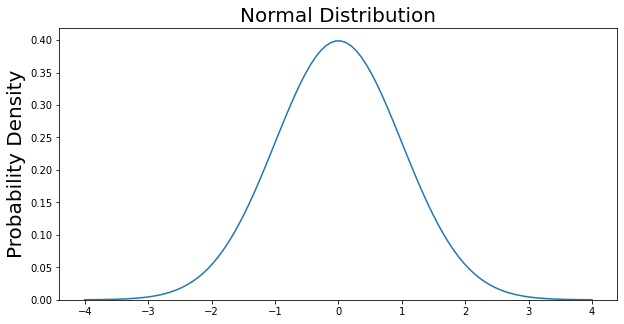

In [855]:

x = np.linspace(-4, 4, num = 100)
constant = 1.0 / np.sqrt(2*np.pi)
pdf_normal_distribution = constant * np.exp((-x**2) / 2.0)
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(x, pdf_normal_distribution);
ax.set_ylim(0);
ax.set_title('Normal Distribution', size = 20);
ax.set_ylabel('Probability Density', size = 20);

In [1387]:
M_Score_perc, _ = quad(normalProbabilityDensity, np.NINF, M_Score) #zweiter Wert ist nicht relevant - daher mit _ ausgegliedert
print("Es liegt eine Wahrscheinlichkeit für einen Betrug gem. Beneish-M-Score von ",M_Score_perc*100, " %", " vor.")
# http://eswf.uni-koeln.de/glossar/zvert.htm --> selbe Wert wie bei Tabelle - Berechnung ist korrekt

M_Score_perc_34, _ = quad(normalProbabilityDensity, np.NINF, M_Score_34) #zweiter Wert ist nicht relevant - daher mit _ ausgegliedert
print("Es liegt eine Wahrscheinlichkeit für einen Betrug gem. Beneish-M-Score von ",M_Score_perc_34*100, " %", " vor.")
# http://eswf.uni-koeln.de/glossar/zvert.htm --> selbe Wert wie bei Tabelle - Berechnung ist korrekt

Es liegt eine Wahrscheinlichkeit für einen Betrug gem. Beneish-M-Score von  24.76104159826676  %  vor.
Es liegt eine Wahrscheinlichkeit für einen Betrug gem. Beneish-M-Score von  7.869001756263362  %  vor.


# Unternehmenskennzahlen S. 365ff (Page: 379ff)

#### Jahr und Vorjahr

In [765]:
### Funktion mit der Error vermeide, wenn durch 0 dividiere
def no_zero_error(x,y):
    try:
        a=x/y
        return a
    except ZeroDivisionError:
        return 0

In [1388]:
# jeweils einzelne Kennzahlen für jedes Jahr + Veränderung der Jahre jeweils darunter

# CR_J, CR_VJ, CR_CHANGE
current_ratio_J= no_zero_error(AssetsCurrent_Jahr,LiabilitiesCurrent_Jahr)
current_ratio_VJ= no_zero_error(AssetsCurrent_Vorjahr,LiabilitiesCurrent_Vorjahr)
change_current_ratio= no_zero_error(current_ratio_J,current_ratio_VJ)

# QR_J, QR_VJ, QR_CHANGE
quick_ratio_J= ( CashAndCashEquivalentsAtCarryingValue_Jahr + MarketableSecurities_Jahr \
    + AccountsReceivableNetCurrent_Jahr) / LiabilitiesCurrent_Jahr
quick_ratio_VJ= ( CashAndCashEquivalentsAtCarryingValue_Vorjahr + MarketableSecurities_Vorjahr \
    + AccountsReceivableNetCurrent_Vorjahr) / LiabilitiesCurrent_Vorjahr
change_quick_ratio= no_zero_error(quick_ratio_J,quick_ratio_VJ)

# INV_J, INV_VJ, INV_CHANGE
av_inventory_J=(InventoryNet_Jahr+(InventoryNet_Jahr - IncreaseDecreaseInInventories_Jahr))/2
av_inventory_VJ=(InventoryNet_Vorjahr+(InventoryNet_Vorjahr - IncreaseDecreaseInInventories_Vorjahr))/2
change_av_inventory= no_zero_error(av_inventory_J,av_inventory_VJ)

# INV_TR_J, INV_TR_VJ, INV_TR_CHANGE
inventory_turnover_ratio_J= no_zero_error(CostOfRevenue_Jahr,av_inventory_J)
inventory_turnover_ratio_VJ= no_zero_error(CostOfRevenue_Vorjahr, av_inventory_VJ)
change_inv_ratio= no_zero_error(inventory_turnover_ratio_J,inventory_turnover_ratio_VJ)

# AV_REC_J, VJ, _CHANGE
av_receivable_J= AccountsReceivableNetCurrent_Jahr + \
    (AccountsReceivableNetCurrent_Jahr - IncreaseDecreaseInAccountsReceivable_Jahr)
av_receivable_VJ = AccountsReceivableNetCurrent_Vorjahr + \
    (AccountsReceivableNetCurrent_Vorjahr - IncreaseDecreaseInAccountsReceivable_Vorjahr)
change_av_receivable=no_zero_error(av_receivable_J,av_receivable_VJ)

# REC_TR_J, _VJ, _CHANGE
receivable_turnover_J=no_zero_error(Revenues_Jahr,av_receivable_J)
receivable_turnover_VJ= no_zero_error(Revenues_Vorjahr,av_receivable_VJ)
change_rec_turnover= no_zero_error(receivable_turnover_J,receivable_turnover_VJ)

# T_LIAB_J, _VJ, _CHANGE
total_liabilities_J = LiabilitiesCurrent_Jahr + LiabilitiesNoncurrent_Jahr
total_liabilities_VJ = LiabilitiesCurrent_Vorjahr + LiabilitiesNoncurrent_Vorjahr
change_liabilities = no_zero_error(total_liabilities_J, total_liabilities_VJ)

# DER_J, _VJ, _CHANGE
debt_equity_ratio_J = no_zero_error(total_liabilities_J, StockholdersEquity_Jahr)
debt_equity_ratio_VJ = no_zero_error(total_liabilities_VJ, StockholdersEquity_Vorjahr)
change_debt_equity_ratio = no_zero_error(debt_equity_ratio_J,debt_equity_ratio_VJ)

# PMR_J, PMR_VJ, PMR_CHANGE
profit_margin_ratio_J = no_zero_error(NetIncomeLoss_Jahr , Revenues_Jahr)
profit_margin_ratio_VJ = no_zero_error(NetIncomeLoss_Vorjahr , Revenues_Vorjahr)
change_profit_margin_ratio = no_zero_error(profit_margin_ratio_J, profit_margin_ratio_VJ)

# AV_ASSET_J, _VJ, _CHANGE
# av_assets_J= (Assets_Jahr + (Assets_Jahr + change_investing_CF_J))
# av_assets_VJ= (Assets_Jahr + (Assets_Jahr + change_investing_CF_J))
av_assets_J= (Assets_Jahr + (Assets_Vorjahr))/2
av_assets_VJ= (Assets_Vorjahr + (Assets_4))/2
av_assets_change = no_zero_error(av_assets_J , av_assets_VJ)

# ASSET_TR_J, ASSET_TR_VJ, _CHANGE
asset_turnover_ratio_J = no_zero_error(Revenues_Jahr , av_assets_J)
asset_turnover_ratio_VJ = no_zero_error(Revenues_Vorjahr ,av_assets_VJ)
asset_turnover_ratio_change = no_zero_error(asset_turnover_ratio_J, asset_turnover_ratio_VJ)


#### Vorjahr und Vor-Vorjahr

In [1389]:
# jeweils einzelne Kennzahlen für jedes Jahr + Veränderung der Jahre jeweils darunter

current_ratio_3= no_zero_error(AssetsCurrent_3,LiabilitiesCurrent_3)
current_ratio_4= no_zero_error(AssetsCurrent_4,LiabilitiesCurrent_4)
change_current_ratio_34= no_zero_error(current_ratio_3,current_ratio_4)

quick_ratio_3= ( CashAndCashEquivalentsAtCarryingValue_3 + \
    MarketableSecurities_3 + AccountsReceivableNetCurrent_3) / LiabilitiesCurrent_3
quick_ratio_4= ( CashAndCashEquivalentsAtCarryingValue_4 + \
    MarketableSecurities_4 + AccountsReceivableNetCurrent_4) / LiabilitiesCurrent_4
change_quick_ratio_34= no_zero_error(quick_ratio_3,quick_ratio_4)

av_inventory_3=(InventoryNet_3+(InventoryNet_3 - IncreaseDecreaseInInventories_3))/2
av_inventory_4=(InventoryNet_4+(InventoryNet_4 - IncreaseDecreaseInInventories_4))/2
change_av_inventory_34= no_zero_error(av_inventory_3,av_inventory_4)

inventory_turnover_ratio_3= no_zero_error(CostOfRevenue_3,av_inventory_J)
inventory_turnover_ratio_4= no_zero_error(CostOfRevenue_4,av_inventory_VJ)
change_inv_ratio_34= no_zero_error(inventory_turnover_ratio_J,inventory_turnover_ratio_VJ)

av_receivable_3= AccountsReceivableNetCurrent_3 + \
    (AccountsReceivableNetCurrent_3 - IncreaseDecreaseInAccountsReceivable_3)
av_receivable_4 = AccountsReceivableNetCurrent_4 + \
    (AccountsReceivableNetCurrent_4 - IncreaseDecreaseInAccountsReceivable_4)
change_av_receivable_34= no_zero_error(av_receivable_3,av_receivable_4)

receivable_turnover_3=no_zero_error(Revenues_3,av_receivable_3)
receivable_turnover_4= no_zero_error(Revenues_4,av_receivable_4)
change_rec_turnover_34= no_zero_error(receivable_turnover_3,receivable_turnover_4)

total_liabilities_3 = LiabilitiesCurrent_3 + LiabilitiesNoncurrent_3
total_liabilities_4 = LiabilitiesCurrent_4 + LiabilitiesNoncurrent_4
change_liabilities_34 = no_zero_error(total_liabilities_3, total_liabilities_4)

debt_equity_ratio_3 = no_zero_error(total_liabilities_3, StockholdersEquity_3)
debt_equity_ratio_4 = no_zero_error(total_liabilities_4, StockholdersEquity_4)
change_debt_equity_ratio_34 = no_zero_error(debt_equity_ratio_3,debt_equity_ratio_4)

profit_margin_ratio_3 = no_zero_error(NetIncomeLoss_3 , Revenues_3)
profit_margin_ratio_4 = no_zero_error(NetIncomeLoss_4 , Revenues_4)
change_profit_margin_ratio_34 = no_zero_error(profit_margin_ratio_3, profit_margin_ratio_4)

#av_assets_J= (Assets_Jahr + (Assets_Jahr + change_investing_CF_J))
#av_assets_VJ= (Assets_Jahr + (Assets_Jahr + change_investing_CF_J))

# AV_ASSET_3, _4, _CHANGE_34
av_assets_3= (Assets_3 + Assets_4)/2
av_assets_4= (Assets_4 + Assets_4)/2
av_assets_change_34 = no_zero_error(av_assets_J , av_assets_VJ)

# ASSET_TR_3, ASSET_TR_4, ASSET_TR_CHANGE
asset_turnover_ratio_3 = no_zero_error(Revenues_3 , av_assets_3)
asset_turnover_ratio_4 = no_zero_error(Revenues_4 , av_assets_4)
asset_turnover_ratio_change_34 = no_zero_error(asset_turnover_ratio_3, asset_turnover_ratio_4)

# F-Score 

In [1390]:
# F-Score

# Accruals quality related variables:

# WC_ACC_J, WC_ACC_VJ
WC_accruals_J =  TATA
WC_accruals_34 = TATA_34

# # RSST accruals Berechnungskomponenten
# total liabili - current liab = non current liablities
NCO_J = (Assets_Jahr - AssetsCurrent_Jahr - investment_non_current_Jahr) -\
     ( LiabilitiesNoncurrent_Jahr  - LongTermDebtNoncurrent_Jahr)
NCO_VJ = (Assets_Vorjahr - AssetsCurrent_Vorjahr - investment_non_current_Vorjahr) - \
    ( LiabilitiesNoncurrent_Vorjahr  - LongTermDebtNoncurrent_Vorjahr)
NCO_3 = (Assets_3 - AssetsCurrent_3 - investment_non_current_3) - \
    ( LiabilitiesNoncurrent_3  - LongTermDebtNoncurrent_3)
NCO_4 = (Assets_4 - AssetsCurrent_4 - investment_non_current_4) - \
    ( LiabilitiesNoncurrent_4  - LongTermDebtNoncurrent_4)

change_NCO_J= NCO_J - NCO_VJ
change_NCO_VJ= NCO_3 - NCO_4
# change_NCO_4 = NCO_4

# FIN = short-term investment + long-term investment) - (longterm debt + short term debt + preferred shares)
FIN_J = (investment_non_current_Jahr + investment_current_Jahr) - \
    (LongTermDebtNoncurrent_Jahr + short_term_debt_Jahr + preferred_stock_Jahr)
FIN_VJ = (investment_non_current_Vorjahr + investment_current_Vorjahr) - \
    (LongTermDebtNoncurrent_Vorjahr + short_term_debt_Vorjahr + preferred_stock_Vorjahr)
FIN_3 = (investment_non_current_3 + investment_current_3) - \
    (LongTermDebtNoncurrent_3 + short_term_debt_3 + preferred_stock_3)
FIN_4 = (investment_non_current_4 + investment_current_4) - \
    (LongTermDebtNoncurrent_4 + short_term_debt_4 + preferred_stock_4)

change_FIN_J = FIN_J - FIN_VJ
change_FIN_VJ = FIN_3 - FIN_4

# RSST accruals-Berechnungsformel
# RSST_ACC_J, RSST_ACC_VJ
RSST_acc_J = (WC_Jahr + change_NCO_J + change_FIN_J)/ av_assets_J
RSST_acc_VJ = (WC_Vorjahr + change_NCO_VJ + change_FIN_VJ)/ av_assets_VJ

# change in receivables / average assets
# CHANGE_REC_AV_J, CHANGE_REC_AV_VJ
change_receivables_J = (AccountsReceivableNetCurrent_Jahr - AccountsReceivableNetCurrent_Vorjahr)/ av_assets_J
change_receivables_VJ = (AccountsReceivableNetCurrent_3 - AccountsReceivableNetCurrent_4) / av_assets_VJ

# change in inventory / average assets
# CHANGE_INV_J, CHANGE_INV_VJ
change_inventory_J = (InventoryNet_Jahr - InventoryNet_Vorjahr) / av_assets_J
change_inventory_VJ = (InventoryNet_3 - InventoryNet_4) / av_assets_VJ

# Total assets (DATA 6) - PP&E (DATA 8) – Cash and cash equivalent (DATA 1))/Total assets (DATA 6
# SOFT_ASSET_J, SOFT_ASSET_VJ
soft_assets_J = (Assets_Jahr - PropertyPlantAndEquipmentNet_Jahr - CashAndCashEquivalentsAtCarryingValue_Jahr)/av_assets_J
soft_assets_VJ = (Assets_Vorjahr - PropertyPlantAndEquipmentNet_Vorjahr - CashAndCashEquivalentsAtCarryingValue_Vorjahr)/av_assets_VJ




In [1391]:
# Performance variables

# CHANGE_CASH_SALES
#change cash sales = Sales - change accounts receivables # lt. Paper Minus - aber es muss Dividiert werden
change_cash_sales_J = Revenues_Jahr - ((AccountsReceivableNetCurrent_Jahr - AccountsReceivableNetCurrent_Vorjahr))
change_cash_sales_VJ = Revenues_3 - ((AccountsReceivableNetCurrent_3 - AccountsReceivableNetCurrent_4))
change_cash_sales = change_cash_sales_J / change_cash_sales_VJ

# CHANGE_CASH_MARGIN_J, _VJ

#change cash margin = 1 - [(cost of good sold - change inventory + change payables) / (sales - change receivables)
# Percentage change in cash margin, where cash margin is  measured as 
# 1- [(Cost of Good sold (DATA 41) - ∆Inventory (DATA 3)+ ∆Accounts payable (DATA70))/(Sales(DATA 12)- ∆Accounts Receivable(DATA 2))] 

change_cash_margin_J = 1 - (((CostOfRevenue_Jahr - (InventoryNet_Jahr - InventoryNet_Vorjahr)) + \
    (AccountsPayableCurrent_Jahr - AccountsPayableCurrent_Vorjahr))/ ( Revenues_Jahr - \
        (AccountsReceivableNetCurrent_Jahr - AccountsReceivableNetCurrent_Vorjahr)))
change_cash_margin_VJ = 1 - (((CostOfRevenue_Vorjahr - (InventoryNet_3 - InventoryNet_4)) + \
    (AccountsPayableCurrent_3 - AccountsPayableCurrent_4))/ \
        ( Revenues_3 - (AccountsReceivableNetCurrent_3 - AccountsReceivableNetCurrent_4)))


# CHANGE_RET_ASSET_J, CHANGE_RET_ASSET_VJ
#change return on assets = earnings/average total assets - (earnings/average total assets --> Vorjahr)
change_return_assets_J = NetIncomeLoss_Jahr / av_assets_J
change_return_assets_VJ = NetIncomeLoss_Vorjahr / av_assets_VJ

#CHANGE_FREE_CF
#change in free cash flows = change von earnings - change von RSST accruals) / average total assets
change_free_cf_J = ((NetIncomeLoss_Jahr - NetIncomeLoss_Vorjahr) - (RSST_acc_J - RSST_acc_VJ))/av_assets_J

# DEF_TAX_EXP_J, DEF_TAX_EXP_VJ
#deferred tax expense = Deferred tax expense for year t (DATA 50) / total assets for year t-1 (DATA 6) 
# Income tax expense = taxes payable + deferred tax liability – deferred tax asset
deferred_tax_expense_J = deferred_tax_expense_Jahr / Assets_Vorjahr
deferred_tax_expense_VJ = deferred_tax_expense_3 / Assets_4

### nachfolgende Punkte werden nicht berechnet
### Grund:
### die Posten sind in ESEF-XBRL-Instanzen nicht enthalten - macht daher keinen Sinn
### Trainingsdaten zu sammeln die für die Testdaten nicht verwendet werden können
# - nonfinancial variables --> nicht durchführbar

# - off-balance-sheet variables

# - market-related incentives

# Altman-Z-Score:

In [1392]:
## Altman-Z-Score

# WC/total assets 
# X_{1} = (Umlaufvermögen – kurzfristige Verbindlichkeiten) / Bilanzsumme,
zscore_V1_J = (AssetsCurrent_Jahr - LiabilitiesCurrent_Jahr) /Assets_Jahr
zscore_V1_VJ = (AssetsCurrent_Vorjahr - LiabilitiesCurrent_Vorjahr) /Assets_Vorjahr

# retained earnings / total assets
# einbehaltene Gewinne / Bilanzsumme,
zscore_V2_J = RetainedEarningsAccumulatedDeficit_Jahr / Assets_Jahr
zscore_V2_VJ = RetainedEarningsAccumulatedDeficit_Jahr / Assets_Vorjahr

# Ergebnis vor Zinsen und Steuern (EBIT)/ Bilanzsumme,
# earnings before interest and taxes/total assets
zscore_V3_J = EBT_Jahr / LiabilitiesAndStockholdersEquity_Jahr
zscore_V3_VJ = EBT_Vorjahr / LiabilitiesAndStockholdersEquity_Vorjahr

# Marktwert des Eigenkapitals / Summe der Verbindlichkeiten,
# market value of equity/book value of total liabilities
zscore_V4_J = market_value_equity_Jahr / (LiabilitiesCurrent_Jahr + LiabilitiesNoncurrent_Jahr)
zscore_V4_VJ = market_value_equity_Vorjahr / (LiabilitiesCurrent_Vorjahr + LiabilitiesNoncurrent_Vorjahr)

# sales/total assets
# Umsatz / Bilanzsumme
zscore_V5_J = Revenues_Jahr / LiabilitiesAndStockholdersEquity_Jahr
zscore_V5_VJ = Revenues_Vorjahr / LiabilitiesAndStockholdersEquity_Vorjahr

zscore_result_J = zscore_V1_J * 1.2 + zscore_V2_J * 1.4 + zscore_V3_J * 3.3 + zscore_V4_J * 0.6 + zscore_V5_J * 0.999
zscore_result_VJ = zscore_V1_VJ * 1.2 + zscore_V2_VJ * 1.4 + zscore_V3_VJ * 3.3 + zscore_V4_VJ * 0.6 + zscore_V5_VJ * 0.999


print("Z-Score im Jahr: ", zscore_result_J, " Z-Score im Vorjahr: ", zscore_result_VJ)

Z-Score im Jahr:  11.252612707207074  Z-Score im Vorjahr:  7.651049532669726


In [ ]:
### Z-Faktor Wert von weniger 1.81 --> hochgradig insolventgefährdet
### Wert größer 2.99 --> ungefährdet

# operativer Cashflow positiv/negativ

In [1393]:
# Kennzahl, die einen Wert von 
# 0 ausgibt, wenn der operative CF negativ ist
# 1 ausgibt, wenn der operative CF positiv bzw. gleich 0 ist
pos1_neg0_o_cf_J = check_if_negativ(CF_operativ_Jahr)
pos1_neg0_o_cf_VJ = check_if_negativ(CF_operativ_Vorjahr)
pos1_neg0_o_cf_4 = check_if_negativ(CF_operativ_4)
print(pos1_neg0_o_cf_J, pos1_neg0_o_cf_VJ, pos1_neg0_o_cf_4)

1 1 1


## Jones + Modified-Jones-Modell

In [1394]:
### Accruals mittels Balance Sheet Methode berechnet
### Current Assets - Current Liabilities - Change Cash - Change Short Term Debt - Depreciation / Total Assets
ACCR_BS_J = (WC_Jahr - change_cash_Jahr - (IDProceedsSTD_Jahr - IDRepaySTD_Jahr) - \
    Depreciation_Jahr)/Assets_Jahr
ACCR_BS_VJ = (WC_Vorjahr - change_cash_Vorjahr - (IDProceedsSTD_Vorjahr - IDRepaySTD_Vorjahr) - \
    Depreciation_Vorjahr)/Assets_Vorjahr
ACCR_BS_3 = (WC_3 - change_cash_3 - (IDProceedsSTD_3 - IDRepaySTD_3) - Depreciation_3)/Assets_3
ACCR_BS_4 = (WC_4 - change_cash_4 - (IDProceedsSTD_4 - IDRepaySTD_4) - Depreciation_4)/Assets_4

print(ACCR_BS_J, ACCR_BS_VJ, ACCR_BS_3, ACCR_BS_4)

0.3330550582366076 0.14252561900534574 0.14252561900534574 0.0044511649699706096


In [1395]:
#### Accruals mittels Cash Flow-Approach berechnet
ACCR_CF_J = (NetIncomeLoss_Jahr - CF_operativ_Jahr)/Assets_Jahr
ACCR_CF_VJ = (NetIncomeLoss_Vorjahr - CF_operativ_Vorjahr)/Assets_Vorjahr
ACCR_CF_3 = (NetIncomeLoss_3 - CF_operativ_3)/Assets_3
ACCR_CF_4 = (NetIncomeLoss_4 - CF_operativ_4)/Assets_4

print(ACCR_CF_J, ACCR_CF_VJ, ACCR_CF_VJ, ACCR_CF_3)

-0.08273319788376818 -0.06585676515429299 -0.06585676515429299 -0.06585676515429299


##### Non Discretionary Accruals

#### Veränderung der Umsätze:

In [1195]:
companyfile_df[companyfile_df["Posten_Art"].str.contains("revenue", case=False)]

,contextRef,unitRef,decimals,id,value,tag_name,Posten_Art,instant,endDate,startDate,{http://www.w3.org/2001/XMLSchema-instance}nil
46,eol_PE74478---1610-K0005_STD_364_20160130_0,iso4217_USD,-3,id_8210242_DCEFDF93-B0D3-46F2-AC7E-06C763E903F...,2725828000,Revenues,revenues_TOP,0,2016-01-30,2015-02-01,0
55,eol_PE74478---1610-K0005_STD_364_20160130_0,iso4217_USD,-3,id_8210242_883C5F3D-01E1-4156-AC0C-DB3DE87E937...,-12398000,IncreaseDecreaseInDeferredRevenue,change_deferred_revenue,0,2016-01-30,2015-02-01,0
70,eol_PE74478---1610-K0005_STD_364_20150131_0,iso4217_USD,-3,id_8210242_DCEFDF93-B0D3-46F2-AC7E-06C763E903F...,3706963000,Revenues,revenues_TOP,0,2015-01-31,2014-02-02,0
79,eol_PE74478---1610-K0005_STD_364_20150131_0,iso4217_USD,-3,id_8210242_883C5F3D-01E1-4156-AC0C-DB3DE87E937...,6373000,IncreaseDecreaseInDeferredRevenue,change_deferred_revenue,0,2015-01-31,2014-02-02,0


In [1397]:
# Umsätze = Revenues vom Vor-Vor-Vorjahr einzugeben - ist händisch einzugeben
revenue_5=int(input("Eingabe Revenues aus dem Vor-Vor-Vorjahr: "))

Eingabe Revenues aus dem Vor-Vorjahr: 68474000


In [1249]:
revenue_5 # Alere Inc.: 2386527000

544155

In [1398]:
change_rev_J=Revenues_Jahr - Revenues_Vorjahr
change_rev_VJ = Revenues_Vorjahr - Revenues_4
change_rev_3 = Revenues_3 - Revenues_4 
change_rev_4 = Revenues_4 - revenue_5

In [1399]:
##### Equation für total-accruals ß, alphas berechnen
var1_J = 1 /Assets_Jahr
var2_J = change_rev_J / Assets_Jahr
var3_J = PropertyPlantAndEquipmentNet_Jahr / Assets_Jahr

var1_VJ = 1 /Assets_Vorjahr
var2_VJ = change_rev_VJ / Assets_Vorjahr
var3_VJ = PropertyPlantAndEquipmentNet_Vorjahr / Assets_Vorjahr

var1_3 = 1 /Assets_3
var2_3 = change_rev_3 / Assets_3
var3_3 = PropertyPlantAndEquipmentNet_3 / Assets_3

var1_4 = 1 /Assets_4
var2_4 = change_rev_4 / Assets_4
var3_4 = PropertyPlantAndEquipmentNet_4 / Assets_4

#nd_J=[var1_J, var2_J, var3_J]
#nd_VJ=[var1_VJ, var2_VJ, var3_VJ]
#nd_3=[var1_3, var2_3, var3_3]
#nd_4=[var1_4, var2_4, var3_4]

# Variable 2 für Modified-Jones Modell
MJ_var2_J = (change_rev_J-IncreaseDecreaseInAccountsReceivable_Jahr) / Assets_Jahr
MJ_var2_VJ = (change_rev_VJ-IncreaseDecreaseInAccountsReceivable_Vorjahr) / Assets_Vorjahr
MJ_var2_3 = (change_rev_3-IncreaseDecreaseInAccountsReceivable_3) / Assets_3
MJ_var2_4 = (change_rev_4-IncreaseDecreaseInAccountsReceivable_4) / Assets_4


# wichtig: Jahr: kann ich nicht verwenden, und Vorjahr ist == 3, daher für Regression und var..._3 und 4 verwendbar !!!!
# Jones Modell
df_acc_Jones = pd.DataFrame([[var1_J, var2_J, var3_J, ACCR_CF_J], [var1_VJ, var2_VJ, var3_VJ, ACCR_CF_VJ], 
                  [var1_3, var2_3, var3_3, ACCR_CF_3], [var1_4, var2_4, var3_4, ACCR_CF_4]], 
                  columns = ["Total_Assets", "Change_in_Revenue", "PPE", "Total_Accruals"])

# Modified Jones Modell
# Veränderung: MJ_var2_... --> Veränderung Receivables werden bei den Revenues berücksichtigt
df_acc_Mod_Jones = pd.DataFrame([[var1_J, MJ_var2_J, var3_J, ACCR_CF_J], [var1_VJ, MJ_var2_VJ, var3_VJ, ACCR_CF_VJ], 
                  [var1_3, MJ_var2_3, var3_3, ACCR_CF_3], [var1_4, MJ_var2_4, var3_4, ACCR_CF_4]], 
                  columns = ["Total_Assets", "Change_in_Revenue_Rec", "PPE", "Total_Accruals"])

In [713]:
df_acc_Mod_Jones

,Total_Assets,Change_in_Revenue_Rec,PPE,Total_Accruals
0,1.334853e-08,-0.006714,0.206473,0.019091
1,1.415374e-08,-0.017621,0.221531,-0.016097
2,1.415374e-08,-0.017621,0.221531,-0.016097
3,1.547722e-08,0.012415,0.242916,-0.027805


In [714]:
df_acc_Jones

,Total_Assets,Change_in_Revenue,PPE,Total_Accruals
0,1.334853e-08,-0.008045,0.206473,0.019091
1,1.415374e-08,-0.017511,0.221531,-0.016097
2,1.415374e-08,-0.017511,0.221531,-0.016097
3,1.547722e-08,0.011303,0.242916,-0.027805


### Jones-Modell

In [1400]:
# Jones-Modell
x_test=df_acc_Jones.iloc[0:1,][["Total_Assets", "Change_in_Revenue", "PPE"]]
x = df_acc_Jones.iloc[2:,][["Total_Assets", "Change_in_Revenue", "PPE"]]
y = df_acc_Jones.iloc[2:,]['Total_Accruals']

#Fitting the Multiple Linear Regression model
mlr = LinearRegression()  
mlr.fit(x, y)
y_pred_Jones = mlr.predict(x_test)[0]

print("Intercept: ", mlr.intercept_)
print("Coefficients:")
print(list(zip(x, mlr.coef_)))
print("Predicted Total Accruals: ", y_pred_Jones)

### Total Accruals:
# df_acc.iloc[0:1,]["Total_Accruals"] 

### Berechnung Discretionary Accruals = DA 
### Annahme: DA sollte bei 0 sein
DA_J = df_acc_Jones.iloc[0:1,]["Total_Accruals"] - y_pred_Jones
DA_J

Intercept:  0.2536514618388861
Coefficients:
[('Total_Assets', -1.513701313182736e-07), ('Change_in_Revenue', -1.3124518275427473), ('PPE', -0.2911431981246754)]
Predicted Total Accruals:  0.02026331355465341


0   -0.102997
Name: Total_Accruals, dtype: float64

### Modified Jones-Modell

In [1401]:

x_test_MJ=df_acc_Mod_Jones.iloc[0:1,][["Total_Assets", "Change_in_Revenue_Rec", "PPE"]]
x_MJ = df_acc_Mod_Jones.iloc[2:,][["Total_Assets", "Change_in_Revenue_Rec", "PPE"]]
y_MJ = df_acc_Mod_Jones.iloc[2:,]['Total_Accruals']

#Fitting the Multiple Linear Regression model
mlr_MJ = LinearRegression()  
mlr_MJ.fit(x_MJ, y_MJ)
y_pred_MJ = mlr.predict(x_test_MJ)[0]

print("Intercept: ", mlr_MJ.intercept_)
print("Coefficients:")
print(list(zip(x, mlr_MJ.coef_)))
print("Predicted Total Accruals: ", y_pred_MJ)

Intercept:  -0.012159189705132786
Coefficients:
[('Total_Assets', 0.0995394235972129), ('Change_in_Revenue', 0.48035681142654196), ('PPE', -8.030912114363272)]
Predicted Total Accruals:  0.05385279752382041


# Eingabe des Unternehmensnamen

In [1402]:
company_name="Tangoe Inc" # Name der Gesellschaft
Jahr_Stichtag # Stichtag letzte Stand
Jahr_Stichtag_34 # Stichtag vom Vorjahr

'2012-12-31'

# Eingabe ob Betrug = 1 oder kein Betrug = 0
# Eingabe eines Wertes stellvertretend für die Art des Betrugs
# im Falle mehrerer Betrugsarten = Eingabe mehrerer Werte
# z.B. Revenue overstated + Expenses understated = 17

# Eingabe einer kurzen Beschreibung des Betrugs (zumeist aus AAER kopiert)

In [1404]:
### Vergabe von Wert für 
### Misstatement: 1
### non misstatment: 0
fraud = 1


#### Type of Fraud
#### no detected fraud = 0
#### Revenue overstated = 1
#### Revenue understated = 2
#### Assets overstated = 3
#### Assets understated = 4
#### Liabilities understated = 5
#### Liabilities overstated = 6
#### Expenses understated = 7
#### Expenses overstated = 8 
#### others - used for personal uses, abstractation of funds - Veruntreuung = 9
#### Kombination der Nummern zeigt, dass mehrere Arten von Betrug begangen wurden
### z.B. Revenue overstated + Expenses understated = 17 und so weiter
#### 
fraud_type=1
anmerkungen= "As alleged in the complaint filed on September 4, 2018, Donald J.\
     Farias was the Senior Vice President of Expense Management Operations for Connecticut-based Tangoe Inc., \
        which improperly recognized approximately $40 million of revenue out of a \
            total of $566 million reported between 2013 and 2015."
print(fraud, fraud_type, anmerkungen)

1 1 As alleged in the complaint filed on September 4, 2018, Donald J. Farias was the Senior Vice President of Expense Management Operations for Connecticut-based Tangoe Inc., which improperly recognized approximately $40 million of revenue out of a total of $566 million reported between 2013 and 2015.


# Sammlung aller Kennzahlen in einer Liste

In [1405]:
all_variables=[company_name, DSRI, DSRI_34, GMI, GMI_34, AQI, AQI_34, SGI, SGI_34, TATA, 
TATA_34, M_Score, M_Score_34, 
current_ratio_J, current_ratio_VJ, current_ratio_3, current_ratio_4, change_current_ratio, change_current_ratio_34, 
quick_ratio_J,quick_ratio_VJ, quick_ratio_3, quick_ratio_4, change_quick_ratio, change_quick_ratio_34, 
av_inventory_J, av_inventory_VJ, av_inventory_3, av_inventory_4, change_av_inventory, change_av_inventory_34, 
inventory_turnover_ratio_J, inventory_turnover_ratio_VJ, inventory_turnover_ratio_3, inventory_turnover_ratio_4, change_inv_ratio, change_inv_ratio_34, 
av_receivable_J, av_receivable_VJ, av_receivable_3, av_receivable_4, change_av_receivable, change_av_receivable_34,
receivable_turnover_J, receivable_turnover_VJ, receivable_turnover_3, receivable_turnover_4, 
change_rec_turnover, change_rec_turnover_34, 
total_liabilities_J, total_liabilities_VJ, total_liabilities_3, total_liabilities_4, 
change_liabilities, change_liabilities_34, 
debt_equity_ratio_J, debt_equity_ratio_VJ, debt_equity_ratio_3, debt_equity_ratio_4, 
change_debt_equity_ratio, change_debt_equity_ratio_34, 
profit_margin_ratio_J, profit_margin_ratio_VJ, profit_margin_ratio_3, profit_margin_ratio_4, 
change_profit_margin_ratio, change_profit_margin_ratio_34, 
av_assets_J, av_assets_VJ, av_assets_3, av_assets_4, av_assets_change, av_assets_change_34, 
asset_turnover_ratio_J, asset_turnover_ratio_VJ,asset_turnover_ratio_3, asset_turnover_ratio_4, 
asset_turnover_ratio_change, asset_turnover_ratio_change_34,
WC_accruals_J, WC_accruals_34, RSST_acc_J, RSST_acc_VJ, 
change_receivables_J, change_receivables_VJ,
change_inventory_J, change_inventory_VJ, 
soft_assets_J, soft_assets_VJ, 
change_cash_sales,change_cash_margin_J, change_cash_margin_VJ, change_return_assets_J, change_return_assets_VJ,change_free_cf_J, 
deferred_tax_expense_J, deferred_tax_expense_VJ,
zscore_V1_J, zscore_V1_VJ, zscore_V2_J, zscore_V2_VJ, zscore_V3_J, zscore_V3_VJ, 
zscore_V4_J, zscore_V4_VJ, zscore_V5_J, zscore_V5_VJ, zscore_result_J, zscore_result_VJ,
fraud, fraud_type, pos1_neg0_o_cf_J, pos1_neg0_o_cf_VJ, pos1_neg0_o_cf_4, Jahr_Stichtag, Jahr_Stichtag_34, anmerkungen,
var1_J, var2_J, var3_J, var1_VJ, var2_VJ, var3_VJ, var1_3, var2_3, var3_3, var1_4, var2_4, var3_4, 
MJ_var2_J, MJ_var2_VJ, MJ_var2_3, MJ_var2_4,
ACCR_BS_J, ACCR_BS_VJ, ACCR_BS_3, ACCR_BS_4, ACCR_CF_J, ACCR_CF_VJ, ACCR_CF_3, ACCR_CF_4,
y_pred_Jones, y_pred_MJ, Anp_abs, Anp_proc]

variable_names=[]
for i in all_variables:
    variable_names.append(namestr(i, globals())[1])
    # print(namestr(i, globals())[1])
    
df_company=pd.DataFrame(all_variables, columns=["Werte"])
df_company["Variable_Namen"]= variable_names

df_company.head(20)

,Werte,Variable_Namen
0,Tangoe Inc,company_name
1,0.923877,DSRI
2,1.02796,DSRI_34
3,0.987062,GMI
4,0.964431,GMI_34
5,0.969077,AQI
6,1.14143,AQI_34
7,1.22265,SGI
8,1.47237,SGI_34
9,0.331043,TATA


In [ ]:
# Code von SQL
# DELETE FROM target_table; --> um sämtliche Inhalte aus SQL-Tabelle zu löschen
# ALTER TABLE dbo.doc_exa ADD column_b VARCHAR(20) NULL, column_c INT NULL ; --> hinzufügen neuer Spalten mit Datentyp
# NULL --> darf NULL-Werte enthalten, NOT NULL: darf keine NULL-Werte beinhalten !!! 
# alter table dbo.Input_SEC_Companies add primary key (Company) --> Primary Key festlegen

## Verbindung zu MS SQL Server - 
## Abspeichern der ermittelten Kennzahlen in der Datenbank

### 119 Verschiedene Variablen: 

In [1406]:
# Verbindung zum lokalen MS SQL Server
conn = pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                      'Server=LAPTOP-J5J6KNQV\MSSQLSERVER01;'
                      'Database=SEC_Companies;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

# Variablen in MS-SQL überführen
# cursor.execute("insert into dbo.Input_SEC_Companies(Company, 
# DSRI, DSRI_1, GMI, GMI_1, AQI, AQI_1, SGI, SQI_1,) values (?);",company_name)
# cursor.execute("insert into dbo.Input_SEC_Companies(Company) values (?);",company_name)

# Spaltennamen der MS-SQL Datenbank-Tabelle
cursor.execute('''insert into dbo.Input_SEC_Companies_3(
Company, DSRI, DSRI_1, GMI, GMI_1, AQI, AQI_1, SGI, SGI_1, TATA, TATA_1, M_Score, M_Score_1, 
CR_J, CR_VJ, CR_3, CR_4, CR_CHANGE, CR_CHANGE_34, 
QR_J,QR_VJ, QR_3, QR_4, QR_CHANGE, QR_CHANGE_34, 
INV_J, INV_VJ, INV_3, INV_4, INV_CHANGE, INV_CHANGE_34, 
INV_TR_J, INV_TR_VJ, INV_TR_3, INV_TR_4, INV_TR_CHANGE, INV_TR_CHANGE_34, 
AV_REC_J,AV_REC_VJ, AV_REC_3,AV_REC_4, AV_REC_CHANGE, AV_REC_CHANGE_34, 
REC_TR_J, REC_TR_VJ, REC_TR_3, REC_TR_4,REC_TR_CHANGE, REC_TR_CHANGE_34, 
T_LIAB_J, T_LIAB_VJ, T_LIAB_3, T_LIAB_4, T_LIAB_CHANGE, T_LIAB_CHANGE_34, 
DER_J, DER_VJ, DER_3, DER_4, DER_CHANGE,DER_CHANGE_34, 
PMR_J, PMR_VJ, PMR_3, PMR_4, PMR_CHANGE, PMR_CHANGE_34, 
AV_ASSET_J, AV_ASSET_VJ, AV_ASSET_3,AV_ASSET_4, AV_ASSET_CHANGE, AV_ASSET_CHANGE_34, 
ASSET_TR_J, ASSET_TR_VJ, ASSET_TR_3, ASSET_TR_4, ASSET_TR_CHANGE, ASSET_TR_CHANGE_34, 
WC_ACC_J,WC_ACC_34, RSST_ACC_J, RSST_ACC_VJ, 
CHANGE_REC_AV_J, CHANGE_REC_AV_VJ, 
CHANGE_INV_J, CHANGE_INV_VJ, 
SOFT_ASSET_J, SOFT_ASSET_VJ,
CHANGE_CASH_SALES,
CHANGE_CASH_MARGIN_J, CHANGE_CASH_MARGIN_VJ, 
CHANGE_RET_ASSET_J, CHANGE_RET_ASSET_VJ, 
CHANGE_FREE_CF, 
DEF_TAX_EXP_J, DEF_TAX_EXP_VJ, 
ZSCORE_1_J, ZSCORE_1_VJ, ZSCORE_2_J,ZSCORE_2_VJ, ZSCORE_3_J, ZSCORE_3_VJ, 
ZSCORE_4_J, ZSCORE_4_VJ,ZSCORE_5_J, ZSCORE_5_VJ, ZSCORE_RESULT_J, ZSCORE_RESULT_VJ, 
FRAUD_1_NONFRAUD_0,FRAUD_TYPE, POS_NEG_O_CF_J, POS_NEG_O_CF_VJ, POS_NEG_O_CF_4, Stichtag, Stichtag_Vorjahr, ANM, 
J_var1_J, J_var2_J, J_var3_J, J_var1_VJ, J_var2_VJ, J_var3_VJ, J_var1_3, J_var2_3, J_var3_3, J_var1_4, J_var2_4, J_var3_4,
MJ_var2_J, MJ_var2_VJ, MJ_var2_3, MJ_var2_4, 
ACCR_BS_J, ACCR_BS_VJ, ACCR_BS_3, ACCR_BS_4, ACCR_CF_J, ACCR_CF_VJ, ACCR_CF_3, ACCR_CF_4,
y_pred_Jones, y_pred_MJ, Anp_abs, Anp_proc) 


values (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,
?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,
?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,
?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);''',
               
               company_name, DSRI, DSRI_34, GMI, GMI_34, AQI, AQI_34, SGI, SGI_34, TATA, 
               TATA_34, M_Score, M_Score_34, 
               current_ratio_J, current_ratio_VJ, current_ratio_3, current_ratio_4, change_current_ratio, change_current_ratio_34, 
               quick_ratio_J,quick_ratio_VJ, quick_ratio_3, quick_ratio_4, change_quick_ratio, change_quick_ratio_34, 
               av_inventory_J, av_inventory_VJ, av_inventory_3, av_inventory_4, change_av_inventory, change_av_inventory_34, 
               inventory_turnover_ratio_J, inventory_turnover_ratio_VJ, inventory_turnover_ratio_3, \
                inventory_turnover_ratio_4, change_inv_ratio, change_inv_ratio_34, 
              av_receivable_J, av_receivable_VJ, av_receivable_3, av_receivable_4, change_av_receivable, change_av_receivable_34,
              receivable_turnover_J, receivable_turnover_VJ, receivable_turnover_3, receivable_turnover_4, 
              change_rec_turnover, change_rec_turnover_34, 
               total_liabilities_J, total_liabilities_VJ, total_liabilities_3, total_liabilities_4, 
               change_liabilities, change_liabilities_34, 
               debt_equity_ratio_J, debt_equity_ratio_VJ, debt_equity_ratio_3, debt_equity_ratio_4, 
               change_debt_equity_ratio, change_debt_equity_ratio_34, 
              profit_margin_ratio_J, profit_margin_ratio_VJ, profit_margin_ratio_3, profit_margin_ratio_4, 
              change_profit_margin_ratio, change_profit_margin_ratio_34, 
               av_assets_J, av_assets_VJ, av_assets_3, av_assets_4, av_assets_change, av_assets_change_34, 
               asset_turnover_ratio_J, asset_turnover_ratio_VJ,asset_turnover_ratio_3, asset_turnover_ratio_4, 
               asset_turnover_ratio_change, asset_turnover_ratio_change_34,
              WC_accruals_J, WC_accruals_34, RSST_acc_J, RSST_acc_VJ, 
               change_receivables_J, change_receivables_VJ,
              change_inventory_J, change_inventory_VJ, 
               soft_assets_J, soft_assets_VJ, 
              change_cash_sales,
               change_cash_margin_J, change_cash_margin_VJ, 
               change_return_assets_J, change_return_assets_VJ,
               change_free_cf_J, 
               deferred_tax_expense_J, deferred_tax_expense_VJ,
              zscore_V1_J, zscore_V1_VJ, zscore_V2_J, zscore_V2_VJ, zscore_V3_J, zscore_V3_VJ, 
               zscore_V4_J, zscore_V4_VJ, zscore_V5_J, zscore_V5_VJ, zscore_result_J, zscore_result_VJ,
               fraud, fraud_type, pos1_neg0_o_cf_J, pos1_neg0_o_cf_VJ, pos1_neg0_o_cf_4, Jahr_Stichtag, Jahr_Stichtag_34, anmerkungen,
              var1_J, var2_J, var3_J, var1_VJ, var2_VJ, var3_VJ, var1_3, var2_3, var3_3, var1_4, var2_4, var3_4, 
              MJ_var2_J, MJ_var2_VJ, MJ_var2_3, MJ_var2_4,
              ACCR_BS_J, ACCR_BS_VJ, ACCR_BS_3, ACCR_BS_4, ACCR_CF_J, ACCR_CF_VJ, ACCR_CF_3, ACCR_CF_4,
              y_pred_Jones, y_pred_MJ, Anp_abs, Anp_proc)


# FRAUD_1_NONFRAUD_0, FRAUD_TYPE
conn.commit()

#cursor.execute('''
 #               INSERT INTO product (product_id, product_name, price)
 #               VALUES
  #              (5,'Chair',120),
   #             (6,'Tablet',300)
  #              ''')
#conn.commit()

# Alle Funktionen, die zum Laden sind

In [6]:
# Funktion die die Posten darauf prüft, ob diese negativ = 0 bzw. positiv bzw. gleich 0 sind = 1
def check_if_negativ(posten):
    if posten < 0:
        return 0
    else:
        return 1

In [7]:
# https://towardsdatascience.com/how-to-use-and-create-a-z-table-standard-normal-table-240e21f36e53
def normalProbabilityDensity(x):
    constant = 1.0 / np.sqrt(2*np.pi)
    return(constant * np.exp((-x**2) / 2.0) )
# Berechnung des Integrals um die kumulative Standardnormalverteilung zu berechnen, mit mü: 0 und Stdabw: 1

In [8]:
# Parsing von Elementen ohne Datum - insbesondere für EntityPublicFloat relevant
# EntityPublicFloat = Marktwert Eigenkapital = Outstanding Shares * current value shares as reporting date

def parsing_wo_date(Suchbegriff, direction):
    tree_def = ET.parse(direction) 
    
# Suchbegriff = "EntityPublicFloat"
    searched=[]
    for element in tree_def.iter():
        if Suchbegriff == element.tag.split("}", 1)[1]:
            tag_name = element.tag.split("}", 1)[1]
            tag_value = element.text
        
            searched.append(tag_name)
            searched.append(int(tag_value))
            
            return searched

In [9]:

def xml_sec_parsing(direction, tax_dir, Jahr_Anfang, VJ_Anfang, VJ_Stichtag, Jahr_Stichtag):
    
    tree_def = ET.parse(direction) # Parsing initialisieren 


    ##############################################################
    x=-1
    context_index=[] # Index-Nummer wo Index in XML-Instanz zu finden ist - wie vielte Tag?
    context_id=[] # enthält den Inhalt des Context-Tag
    instant_index=[]
    instant_id=[]
    startDate_id=[]
    startDate_index=[]
    endDate_id=[]
    endDate_index=[]
    explicitMember_index=[]
    explicitMember_id=[]

    for element in tree_def.iter(): # xsd
        x=x+1
        if "context" in element.tag:
            context_id.append(element.attrib.values()) # speichert Inhalt von Context-Tag
            context_index.append(x) # speichert Index-Nummer von Context-Tag
            # nach Context-Tag kommt immer entweder: instant (Stichtag) oder startDate und endDate (periodenbezogen)
            # also die nachfolgende Tags untersuchen, ob instant oder start- endDate haben und Inhalte speichern
        elif "instant" in element.tag:
            instant_id.append(element.text)
            instant_index.append(x)
        elif "startDate" in element.tag:
            startDate_id.append(element.text)
            startDate_index.append(x)
        elif "endDate" in element.tag:
            endDate_id.append(element.text)
            endDate_index.append(x)  
        elif "explicitMember" in element.tag: # prüfe ob explicitMember enthalten ist - denn diese contextRefs brauche ich nicht
            # enthält meist Axis Daten - also Teile von Aggregationen 
            explicitMember_id.append(element.attrib)
            explicitMember_index.append(x)

            #print(element.attrib) 


    ##################################################        

    # alle Index-Werte in eine Liste zusammenfügen
    full_index=context_index.copy()
    full_index.extend(instant_index)
    full_index.extend(startDate_index)
    full_index.extend(endDate_index)

    #Erweiterung um explicitMember-Index-Werte
    full_index.extend(explicitMember_index)



    ############################################

    # erzeugen von 5 DataFrames, mit Context, Instant-Date, startdate und enddate
    # jedes DataFrame enthält Inhalt von XML, Index-Nr von XML und jeweils Index-Bezeichnung: z.B. context, instant, enddate, startDate

    df_context = pd.DataFrame(context_index, context_id,  columns=["id"]).reset_index()
    df_instant = pd.DataFrame(instant_index, instant_id, columns=["id"]).reset_index()
    df_startDate = pd.DataFrame(startDate_index, startDate_id, columns=["id"]).reset_index()
    df_endDate = pd.DataFrame(endDate_index, endDate_id, columns=["id"]).reset_index()
    # explicitMember
    df_explicitMember = pd.DataFrame(explicitMember_index, explicitMember_id, columns=["id"]).reset_index()


    # jeder Dataframe bekommt auf jeder Zeile den Namen des Tags zugewiesen
    df_context["name"]=["context"]*len(context_index)
    df_instant["name"]=["instant"]*len(instant_index)
    df_startDate["name"]=["startDate"]*len(startDate_index)
    df_endDate["name"]=["endDate"]*len(endDate_index)
    #explicit Member
    df_explicitMember["name"]=["explicitMember"]*len(explicitMember_index)

    # Zusammenfügen aller Dataframes
    frames = [df_context, df_instant, df_startDate, df_endDate, df_explicitMember]
    result = pd.concat(frames)


    result_sorted=result.sort_values(by=['id']) # Sortieren nach id

    # pivot = reshape des Datframe
    result_sorted_pivot=result_sorted.pivot(index="id", columns="name", values="index")
    # dadurch folgenden Ausgabe:
    # name	context	                                     endDate	instant	startDate
    # 4069	(eol_PE89370---1410-K0012_STD_92_20110930_0)	NaN	      NaN	   NaN
    # 4073	NaN	                                             NaN	NaN	    2011-07-01
    # 4074	NaN	                                         2011-09-30	 NaN	  NaN


    context_column_only_df=result_sorted_pivot["context"]

    # befülle alle nachfolgenden Spaltenwerte mit NaN mit vorherigen context-Inhalt
    # forward-fill
    # befüllt nachfolgende NaN-Werte mit vorherigen context-Inhalt
    context_column_only_df_fill=context_column_only_df.fillna(method='ffill') 

    # befülle die vollständigen context-Inhalte in den DataFrame
    result_sorted_pivot["context"]=context_column_only_df_fill
    # jetzt keine NaN-Werte mehr vorhanden


    # groupby-Funktion - Ziel: noch sind die Daten auf mehreren Zeilen verteilt
    # z.B. startDate und endDate hat zwar jeweils gleiche context-id 
    # aber stehen auf unterschiedlichen Zeilen
    # damit stehen diese nun auf derselben Zeile
    # bei Alere Inc aus ca. 1900 --> 732 Zeilen beschränkt

    ############################################################################################
    # Ziel aus dict_values(['eol_PE89370---1410-K0012_STD_91_20140630_0'])
    # wird 'eol_PE89370---1410-K0012_STD_91_20140630_0'
    # hoffentlich geht dann Fehlermeldung weg !!!!!!!!!

    ohne_dict_values=[]
    for i in range(0, len(result_sorted_pivot)):
        ohne=str(result_sorted_pivot.iloc[i,0]).split('[', 1)[1].split(']')[0].replace("'", "")
        ohne_dict_values.append(ohne)



    result_sorted_pivot["context"]=ohne_dict_values

    aggregation_functions = {'endDate': 'first', 'instant': 'first', 'startDate': 'first', "explicitMember":'first'}
    result_sorted_all_only_ones=result_sorted_pivot.groupby(['context']).aggregate(aggregation_functions)

    result_sorted_all_only_ones=result_sorted_all_only_ones.fillna(0)


    # neu dazu, um nur relevantes zu behalten
    ### Behalte nur jene context-Ref Daten, wo keine Dimensionsdaten in Spalte explicitMember enthalten sind
    context_result=[]
    for i in range(0, len(result_sorted_all_only_ones)):
        if isinstance(result_sorted_all_only_ones["explicitMember"][i], int):
            a=result_sorted_all_only_ones.iloc[i,:]
            context_result.append(a)

            # Anzahl stark reduziert und jetzt in ein DataFrame umwandeln - schaut gut aus
    result_sorted_all_only_ones=pd.DataFrame(context_result)

    # bei Alere Inc: 18 Ergebnisse - Durchsicht zeigt es gibt nur 4 contextRefs die den gesuchten Zeitraum angeben - es dürfte funktioniert haben :)


    ####################################################################################################


    ### Gesamtabfrage in einer Zeile Code in einer Variable gespeichert statt in 4 Variablen!!!! 
    # Werte in Periodenzeitraum: 1.1.2014 bis 31.12.2014
    #Jahr_Anfang="2014-01-01"
    # Werte in Periodenzeitraum: 1.1.2013 bis 31.12.2013
    #VJ_Anfang="2013-01-01"
    # Filterung Stichtag Vorjahr
    #VJ_Stichtag="2013-12-31"
    #Filterung Stichtag des Jahresabschluss (dieses Jahr)
    #Jahr_Stichtag="2014-12-31"

    context_ids=result_sorted_all_only_ones[\
        (result_sorted_all_only_ones["instant"].str.contains(Jahr_Stichtag, na=False)) | \
            (result_sorted_all_only_ones["instant"].str.contains(VJ_Stichtag, na=False)) |\
                (result_sorted_all_only_ones["startDate"].str.contains(Jahr_Anfang, na=False)) & \
                    (result_sorted_all_only_ones["endDate"].str.contains(Jahr_Stichtag, na=False)) | \
                        (result_sorted_all_only_ones["startDate"].str.contains(VJ_Anfang, na=False)) & \
                            (result_sorted_all_only_ones["endDate"].str.contains(VJ_Stichtag, na=False))]

    ##########################################################################################

    # Abspeichern der Attribut-Inhalte und Values die im XML-File enthalten sind - 
    # nur jene Posten inkludiert, die auch im SEC-Taxonomie File enthalten sind

    name_attribut=[] # speichert Attribut-Inhalte von context
    name_value=[] # speichert Werte
    tag_names=[] # speichert tag-namen
    posten_arten=[] # speichert die Postenarten z.B. revenues_TOP, (also eigene Bezeichnungen zu tag-names)
    for element in tree_def.iter():
        for tax_element in range(0, len(tax_dir_np)):
            # Abgleich mit in --> nicht gut geeignet, da es nur nach Ähnlichkeiten sucht --> daher == zu verwenden
            if tax_dir_np[tax_element,2] == str(element.tag.split("}", 1)[1]): #suche Taxonomie Element aus Excel file in XBRL-Instanz
                #Zwischenspeichern der Inhalte
                tags=element.tag.split("}", 1)[1] # splitten des Tags - nur Tag-Name übernehmen, Rest fällt weg
                name=element.attrib # Speichere Attribut-Inhalt von Tag in eigener Liste
                value=element.text
                
                # Posten_Art aus tax_dir-File noch hinzufügen
                posten_art=tax_dir_np[tax_element, 0]
                

                # befüllen der Listen
                tag_names.append(tags)
                name_attribut.append(name)
                name_value.append(value)
                posten_arten.append(posten_art)

    # In die Liste mit jeweils einem Dict an jeder Stelle - neue Keys einfügen, in denen die Tag-Names und die Values enthalten sind
    for i in range(0, len(name_attribut)):
        name_attribut[i]["value"]=name_value[i] # jeder Value aus Liste name_value wird in name_attribut eingefügt
        name_attribut[i]["tag_name"]=tag_names[i]
        name_attribut[i]["Posten_Art"]=posten_arten[i]

    ########################################################################################################################

    # Herausfiltern jener name_attribut Elemente, die context_Ref (also Zeitraum Betreffen) der unrelevant ist

    # für Alere Inc z.B. nur 1.1.2013 - 31.12.2013, 1.1.2014 - 31.12.2014, 31.12.2014 und 31.12.2013 relevant

    # Rest ist überflüssig

    instants=[] # speichern der instant-Daten
    endDates=[] # speichern der endDate-Daten
    startDates=[] # speichern der startDate-Daten

    relevante_attribute=[]
    for i in range(0, len(name_attribut)): # jeden contextRef durchiterieren in XBRL-Instanz
        for j in range(0, len(context_ids)): # jeden contextRef durchiterieren mit relevanten ids. 
            # prüfe, wenn id aus XBRL-Instanz relevant ist dann:
            if name_attribut[i].get('contextRef') == context_ids.index[j]:
                rel=name_attribut[i]
                ### speichern von Instant, startDate und endDate
                instant_date=context_ids["instant"][j]
                endDate=context_ids["endDate"][j]
                startDate=context_ids["startDate"][j]
                instants.append(instant_date)
                endDates.append(endDate)
                startDates.append(startDate)
                relevante_attribute.append(rel)

    for i in range(0, len(relevante_attribute)):
        relevante_attribute[i]["instant"]=instants[i] # jeder Value aus Liste name_value wird in name_attribut eingefügt
        relevante_attribute[i]["endDate"]=endDates[i]
        relevante_attribute[i]["startDate"]=startDates[i]

    df_result=pd.DataFrame(relevante_attribute)
    
    return relevante_attribute

In [10]:
### Funktion, der die stufe_2 Liste erzeugt, in der alle "Stufe_2" Posten enthalten sind
# taxonomy_file --> importierte Excel Datei = DataFrame mit alle zu suchenden Tag_names
# Suchbegriff --> Posten_Art die gesucht wird (--> selbst definierte Kategorie) z.B. "revenues"


def stufe_2_liste_erzeugen(taxonomy_file, Suchbegriff):
    stufe_2_liste=[] # leere Liste
    
    # Iteration durch das Taxonomy-File --> so dass jeder Tag-name einzeln hinzugefügt wird
    # und nicht mehr als gesamter Block 
    for i in range(0, len(taxonomy_file[taxonomy_file["Posten_Art"] == Suchbegriff])):
        a = taxonomy_file[taxonomy_file["Posten_Art"] == Suchbegriff].iloc[i,2]
    
        # Zuweisung der tag-Names in eine Liste
        stufe_2_liste.append(a)
    
    return stufe_2_liste

# Definierte Funktionen für duration und instant Werte - ursprüngliche Versionen 

### Aufgrund hoher Fehleranfälligkeit ersetzt

### Alternative: statt beide Jahre - nur ein Jahr abfragen, um Fehler zu vermeiden

In [11]:
def kombo_posten_zuweisung_duration_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    try:
        return posten_zuweisung_stufenweise_duration_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)
    except:
        return posten_zuweisung_stufenweise_duration_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)

In [12]:
# Version vom 26.04.2022 --> neu: If-Statements nach Try, um Fehler abzufangen, wenn kein Treffer zu finden ist
# nur für Fehlermeldungen verwendbar, wenn es einen Posten nicht gibt

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # nur wenn es einen Treffer gibt, dann wird es in ein Integer umgewandelt
        if len(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Jahr, case=False))]) > 0:
            
            step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        else:
            step_1_value_J = 0
        # Vorjahres-Ergebnisse
        
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        #stufe_1_liste.append(step_1_value_VJ)
        

        return stufe_1_liste
        
    except TypeError: 
        
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    #step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    #stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
        
            
        return stufe_2_liste
            

In [13]:
# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten 
# vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # diesjähriges Ergebnis
        step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # Vorjahres-Ergebnisse
        #step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
       # stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    #step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                   # stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
                    
            
        return stufe_2_liste
            

In [14]:
def kombo_posten_zuweisung_duration(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    try:
        return posten_zuweisung_stufenweise_duration(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr)
    except:
        return posten_zuweisung_stufenweise_duration_ERROR(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr)

In [15]:
# Version vom 26.04.2022 --> neu: If-Statements nach Try, um Fehler abzufangen, wenn kein Treffer zu finden ist
# nur für Fehlermeldungen verwendbar, wenn es einen Posten nicht gibt

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, 
# aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration_ERROR(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # nur wenn es einen Treffer gibt, dann wird es in ein Integer umgewandelt
        if len(company_file[(company_file["tag_name"] == stufe_1) & (company_file["endDate"].str.contains(Datum_Jahr, case=False))]) > 0:
            
            step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) &\
                 (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        else:
            step_1_value_J = 0
        # Vorjahres-Ergebnisse
        
        if len(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]) > 0:
            step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
        
        else:
            step_1_value_VJ = 0
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        

        return stufe_1_liste
        
    except TypeError: 
        
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        # neu
        if len(stufe_2_liste) == 1: # wenn nur ein Wert für ein Jahr vorhanden ist - füge einmal eine Null hinzu
            stufe_2_liste.append(0)
        
        elif len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
        
            
        return stufe_2_liste
            

In [16]:
# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # diesjähriges Ergebnis
        step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # Vorjahres-Ergebnisse
        step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        # neu
        if len(stufe_2_liste) == 1: # wenn nur ein Wert für ein Jahr vorhanden ist - füge einmal eine Null hinzu
            stufe_2_liste.append(0)
        
        elif len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
                    
            
        return stufe_2_liste
            

In [17]:
def kombo_posten_zuweisung_instant_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    try:
        return posten_zuweisung_stufenweise_instant_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)
    except:
        return posten_zuweisung_stufenweise_instant_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr)

In [18]:
# Version vom 26.04.2022 --> neu: If-Statements nach Try, um Fehler abzufangen, wenn kein Treffer zu finden ist
# nur für Fehlermeldungen verwendbar, wenn es einen Posten nicht gibt

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, 
# aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_instant_ERROR_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # nur wenn es einen Treffer gibt, dann wird es in ein Integer umgewandelt
        if len(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Jahr, case=False))]) > 0:
            
            # am Ende [0] - also nehme nur ersten Wert
            step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        else:
            step_1_value_J = 0
        # Vorjahres-Ergebnisse
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        # stufe_1_liste.append(step_1_value_VJ)
        

        return stufe_1_liste
        
    except TypeError: 
        
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    # step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) &
                    #  (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    #stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1: # wenn überhaupt kein Treffer vorhanden ist - füge Nuller ein
            stufe_2_liste.append(0)
   
            
        return stufe_2_liste
            

In [19]:
# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_instant_one_year(company_file, stufe_1, stufe_2, Datum_Jahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # am Ende [0] - also nehme nur ersten Wert
        # diesjähriges Ergebnis
        step_1_value_J=list(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # am Ende [0] - also nehme nur ersten Wert
        # Vorjahres-Ergebnisse
        #step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        #stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2: # Iteration durch stufe_2 liste
            # set von company_file - da Postennamen stets mind. 2x vorhanden sind
            # einmal Jahr z.B. 2014 und einmal 2013 
            # ohne set würde es den Postennamen 2x nehmen und ich habe die Werte 4x ausgegeben 
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=list(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    #step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    #stufe_2_liste.append(step_2_value_VJ)
                    
                # für den Fall, dass keiner der Werte vorhanden ist, 
                # wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)

            
        return stufe_2_liste
            

### doppel-Abfrage beide Jahre - sehr Fehleranfällig:

In [20]:
def kombo_posten_zuweisung_instant(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    try:
        return posten_zuweisung_stufenweise_instant(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr)
    except:
        return posten_zuweisung_stufenweise_instant_ERROR(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr)

In [22]:
# Version vom 26.04.2022 --> neu: If-Statements nach Try, um Fehler abzufangen, wenn kein Treffer zu finden ist
# nur für Fehlermeldungen verwendbar, wenn es einen Posten nicht gibt

# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_instant_ERROR(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # nur wenn es einen Treffer gibt, dann wird es in ein Integer umgewandelt
        if len(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Jahr, case=False))]) > 0:
            
            # am Ende [0] - also nehme nur ersten Wert
            step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        else:
            step_1_value_J = 0
        # Vorjahres-Ergebnisse
        
        if len(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]) > 0:
            
            # am Ende [0] - also nehme nur ersten Wert
            step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
                (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
        
        else:
            step_1_value_VJ = 0
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        

        return stufe_1_liste
        
    except TypeError: 
        
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 
        # 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        # neu
        if len(stufe_2_liste) == 1: # wenn nur ein Wert für ein Jahr vorhanden ist - füge einmal eine Null hinzu
            stufe_2_liste.append(0)
            
        elif len(stufe_2_liste)<1: # wenn überhaupt kein Treffer vorhanden ist - füge zweimal Nuller ein
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
        
            
        return stufe_2_liste
            

In [23]:
# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_instant(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # am Ende [0] - also nehme nur ersten Wert
        # diesjähriges Ergebnis
        step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # am Ende [0] - also nehme nur ersten Wert
        # Vorjahres-Ergebnisse
        step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2: # Iteration durch stufe_2 liste
            # set von company_file - da Postennamen stets mind. 2x vorhanden sind
            # einmal Jahr z.B. 2014 und einmal 2013 
            # ohne set würde es den Postennamen 2x nehmen und ich habe die Werte 4x ausgegeben 
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) &\
                         (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])[0]
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])[0]
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        # neu
        if len(stufe_2_liste) == 1: # wenn nur ein Wert für ein Jahr vorhanden ist - füge einmal eine Null hinzu
            stufe_2_liste.append(0)
        
        elif len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
            
        return stufe_2_liste
            

In [ ]:
# Beispielhafte Aufstellung wie die Werte zu den jeweiligen Tags im XBRL-Dokument ausgewiesen sind

In [503]:
companyfile

[{'contextRef': 'eol_PE89370---1410-K0012_STD_0_20131231_0',
  'unitRef': 'iso4217_USD',
  'decimals': '-3',
  'id': 'id_6670856_5E6C8408-A5BA-4446-AD57-C3872344AE0E_2_21',
  'value': '112525000',
  'tag_name': 'OtherLiabilitiesCurrent',
  'Posten_Art': 'current_liabilities',
  'instant': '2013-12-31',
  'endDate': 0,
  'startDate': 0},
 {'contextRef': 'eol_PE89370---1410-K0012_STD_0_20131231_0',
  'unitRef': 'iso4217_USD',
  'decimals': '-3',
  'id': 'id_6670856_EC7453BD-F7F0-4615-98EA-B279BEB0A228_2_29',
  'value': '748485000',
  'tag_name': 'LiabilitiesCurrent',
  'Posten_Art': 'current_liabilities',
  'instant': '2013-12-31',
  'endDate': 0,
  'startDate': 0},
 {'contextRef': 'eol_PE89370---1410-K0012_STD_0_20131231_0',
  'unitRef': 'iso4217_USD',
  'decimals': '-3',
  'id': 'id_6670856_EC7453BD-F7F0-4615-98EA-B279BEB0A228_2_35',
  'value': '4229481000',
  'tag_name': 'LiabilitiesNoncurrent',
  'Posten_Art': 'non_current_liabilities',
  'instant': '2013-12-31',
  'endDate': 0,
  's

# Code vor dem 26.04.2022 - Veralterte Lösungsansätze:

# Definition stufe_1

In [376]:
stufe_1="Revenues" #tag-name den primär suche 

In [423]:
### Funktion, der die stufe_2 Liste erzeugt, in der alle "Stufe_2" Posten enthalten sind
# taxonomy_file --> importierte Excel Datei = DataFrame mit alle zu suchenden Tag_names
# Suchbegriff --> Posten_Art die gesucht wird (--> selbst definierte Kategorie) z.B. "revenues"


def stufe_2_liste_erzeugen(taxonomy_file, Suchbegriff):
    stufe_2_liste=[] # leere Liste
    
    # Iteration durch das Taxonomy-File --> so dass jeder Tag-name einzeln hinzugefügt wird
    # und nicht mehr als gesamter Block 
    for i in range(0, len(taxonomy_file[taxonomy_file["Posten_Art"] == Suchbegriff])):
        a = taxonomy_file[taxonomy_file["Posten_Art"] == Suchbegriff].iloc[i,2]
    
        # Zuweisung der tag-Names in eine Liste
        stufe_2_liste.append(a)
    
    return stufe_2_liste

# Festlegung stufe_2

# Festlegung Datum und Vorjahr --> bereits oben definiert

In [ ]:
### Zusammenfassendes Beispiel, wie die Posten-Werte für revenues ausgegeben werden können 

# Definierte Funktionen für duration und instant Werte - ursprüngliche Version vor dem 26.04.2022
# Abfrage von zwei Werten auf einmal 

In [477]:
# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_duration(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # diesjähriges Ergebnis
        step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # Vorjahres-Ergebnisse
        step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) &
        #  (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2:
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) &\
                         (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["value"])
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) &
                    #  (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
                    
            
        return stufe_2_liste
            

In [487]:
# accounts_receivables_net

# change income tax
stufe_1="Receivable" 
Suchbegriff="accounts_receivables_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# change_income_tax_Jahr, change_income_tax_Vorjahr =  
# posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)
posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


[0, 0]

In [488]:
# company_file: DataFrame mit allen herausgefilterten Posten der XBRL-Instanz
# stufe_1: Liste mit den primären Tag_names die in 99% der Fälle passen dürften z.B. Revenues
# Stufe_2: Liste mit den sekundären Tag_names, die eher selten vorkommen, 
# aber ebenso durchsucht werden müssen, wenn Stufe 1 keinen Treffer liefert
# Datum: Datum des gesuchten Zeitraums/Zeitpunkts Jahr: dieses Jahr, Vorjahr: vorherige Jahr
def posten_zuweisung_stufenweise_instant(company_file, stufe_1, stufe_2, Datum_Jahr, Datum_Vorjahr):
    stufe_1_liste=[]
    stufe_2_liste=[]
    try:
        # Versuche den Stufe 1 Wert zu finden:
        # z.B. bei "Revenues" wird gesucht, ob der Posten Revenues enthalten ist
        
        # diesjähriges Ergebnis
        step_1_value_J=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])
        #step_1_name_J=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Jahr, case=False))]["tag_name"]
        
        # Vorjahres-Ergebnisse
        step_1_value_VJ=int(company_file[(company_file["tag_name"] == stufe_1) & \
            (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])
        #step_1_name_VJ=company_file[(company_file["tag_name"] == stufe_1) & 
        # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]
    
        #stufe_1_liste.append(step_1_name_J)
        stufe_1_liste.append(step_1_value_J)
        #stufe_1_liste.append(step_1_name_VJ)
        stufe_1_liste.append(step_1_value_VJ)
        
        return stufe_1_liste
        
    except: 
        # Wenn die Suche nach dem Stufe 1 Posten also jenen Posten der in 99% der Fälle passen dürfte, erfolglos bleibt,
        # dann wird die Suche um alle Stufe 2 Posten erweitert
        # also weniger allgemeine Begriffe, die aber ebenso passend sein können
        
        # Iteration der stufe_2 Liste auf mögliche Treffer: 
        for wort_stufe_2 in stufe_2: # Iteration durch stufe_2 liste
            # set von company_file - da Postennamen stets mind. 2x vorhanden sind
            # einmal Jahr z.B. 2014 und einmal 2013 
            # ohne set würde es den Postennamen 2x nehmen und ich habe die Werte 4x ausgegeben 
            for tag_name_cf in set(company_file["tag_name"]): # Iteration durch XBRL-Instanz Spalte
                if wort_stufe_2 == tag_name_cf: # nur wenn es einen Treffer gibt, dann führe nachfolgende Abfragen aus:
            
                    # abspeichern des Wertes und des Postennamens/Tag_names
                    step_2_value_J=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Jahr, case=False))]["value"])
                    #step_2_name_J=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum, case=False))]["tag_name"]

                    step_2_value_VJ=int(company_file[(company_file["tag_name"] == wort_stufe_2) & \
                        (company_file["instant"].str.contains(Datum_Vorjahr, case=False))]["value"])
                    #step_2_name_VJ=company_file[(company_file["tag_name"] == wort_stufe_2) & 
                    # (company_file["endDate"].str.contains(Datum_Vorjahr, case=False))]["tag_name"]

                    # speichere Werte in einer Liste ab 
                    #stufe_2_liste.append(step_2_name_J)
                    stufe_2_liste.append(step_2_value_J)
                    #stufe_2_liste.append(step_2_name_VJ)
                    stufe_2_liste.append(step_2_value_VJ)
                    
                # für den Fall, dass keiner der Werte vorhanden ist, wird defaultmäßig die Werte 0 für beide Jahre zugewiesen
        if len(stufe_2_liste)<1:
            stufe_2_liste.append(0)
            stufe_2_liste.append(0)
            
        return stufe_2_liste
            

# duration-Werte GuV (periodenbezogene Werte)

### Jahr + Vorjahr 

In [498]:
stufe_1="Revenues" #tag-name den primär suche 
Suchbegriff="revenues"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
# Zuweisung der Werte für Revenues in diesem und im Vorjahr
Revenues_Jahr, Revenues_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="CashAndCashEquivalentsPeriodIncreaseDecrease" 
Suchbegriff="cash_and_cash_equivalents_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
change_cash_Jahr, change_cash_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="CostOfRevenue" 
Suchbegriff="cost_of_goods"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
CostOfRevenue_Jahr, CostOfRevenue_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="Depreciation" 
Suchbegriff="depreciation_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
Depreciation_Jahr, Depreciation_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="DepreciationAndAmortization" 
Suchbegriff="depreciation_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
DepreciationAndAmortization_Jahr, DepreciationAndAmortization_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="GeneralAndAdministrativeExpense" 
Suchbegriff="general_administrative_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
GeneralAndAdministrativeExpense_Jahr, GeneralAndAdministrativeExpense_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments" 
Suchbegriff="earnings_before_taxes_EBT"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
EBT_Jahr, EBT_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="IncreaseDecreaseInAccountsPayable" 
Suchbegriff="change_acc_payables_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
IncreaseDecreaseInAccountsPayable_Jahr, IncreaseDecreaseInAccountsPayable_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="IncreaseDecreaseInAccountsReceivable" 
Suchbegriff="change_receivables_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
IncreaseDecreaseInAccountsReceivable_Jahr, IncreaseDecreaseInAccountsReceivable_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="IncreaseDecreaseInInventories" 
Suchbegriff="change_inventory"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
IncreaseDecreaseInInventories_Jahr, IncreaseDecreaseInInventories_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="NetCashProvidedByUsedInOperatingActivitiesContinuingOperations" 
Suchbegriff="change_current_assets_liabilities" # = Veränderung Working Capital
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
WC_Jahr, WC_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="NetIncomeLoss" 
Suchbegriff="net_income_loss"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
NetIncomeLoss_Jahr, NetIncomeLoss_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="ProceedsFromIssuanceOfLongTermDebt" 
Suchbegriff="change_LTD_borrow"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
change_LTD_borrow_Jahr, change_LTD_borrow_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="RepaymentsOfLongTermDebt" 
Suchbegriff="change_LTD_payment"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
change_LTD_payment_Jahr, change_LTD_payment_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

# Cashflows Operativ, Investing und Financing:

stufe_1="NetCashProvidedByUsedInOperatingActivities" 
Suchbegriff="cashflow_operativ"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
CF_operativ_Jahr, CF_operativ_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="NetCashProvidedByUsedInInvestingActivities" 
Suchbegriff="cashflow_investing"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
CF_investing_Jahr, CF_investing_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="NetCashProvidedByUsedInFinancingActivities" 
Suchbegriff="cashflow_financing"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
CF_financing_Jahr, CF_financing_Vorjahr =  posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

# change income tax
stufe_1="IncreaseDecreaseInIncomeTaxes" 
Suchbegriff="change_income_tax_payables"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
change_income_tax_Jahr, change_income_tax_Vorjahr = posten_zuweisung_stufenweise_duration(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


# instant-Werte Bilanz und  (Stichtagsbezogene Werte)

### Jahr + Vorjahr 

In [494]:

####################################
# instant-Werte Bilanz und CF-Werte (Stichtagsbezogene Werte)
stufe_1="AccountsPayableCurrent" 
Suchbegriff="accounts_payable"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
AccountsPayableCurrent_Jahr, AccountsPayableCurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="AccountsReceivableNetCurrent" 
#stufe_2=["AccountsReceivableNet"] 
Suchbegriff="accounts_receivables_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
AccountsReceivableNetCurrent_Jahr, AccountsReceivableNetCurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="Assets" 
Suchbegriff="total_assets"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
Assets_Jahr, Assets_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="AssetsCurrent" 
Suchbegriff="current_assets_total"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
AssetsCurrent_Jahr, AssetsCurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="CashAndCashEquivalentsAtCarryingValue" 
Suchbegriff="cash_and_cash_equivalents_TOP"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
CashAndCashEquivalentsAtCarryingValue_Jahr, CashAndCashEquivalentsAtCarryingValue_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="InventoryFinishedGoodsNetOfReserves" 
Suchbegriff="inventory"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
InventoryFinishedGoodsNetOfReserves_Jahr, InventoryFinishedGoodsNetOfReserves_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="InventoryNet" 
Suchbegriff="inventory_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
InventoryNet_Jahr, InventoryNet_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="LiabilitiesAndStockholdersEquity" 
Suchbegriff="total_liabilities_equity"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
LiabilitiesAndStockholdersEquity_Jahr, LiabilitiesAndStockholdersEquity_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="LiabilitiesCurrent" 
Suchbegriff="current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
LiabilitiesCurrent_Jahr, LiabilitiesCurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="LiabilitiesNoncurrent" 
Suchbegriff="non_current_liabilities"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
LiabilitiesNoncurrent_Jahr, LiabilitiesNoncurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="LongTermDebtNoncurrent" 
Suchbegriff="LTD_LongTermDebt"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
LongTermDebtNoncurrent_Jahr, LongTermDebtNoncurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="OtherAssetsNoncurrent" 
Suchbegriff="non_current_assets_total"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
OtherAssetsNoncurrent_Jahr, OtherAssetsNoncurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="PropertyPlantAndEquipmentGross" 
Suchbegriff="PPE_gross"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
PropertyPlantAndEquipmentGross_Jahr, PropertyPlantAndEquipmentGross_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="PropertyPlantAndEquipmentNet" 
Suchbegriff="PPE_net"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
PropertyPlantAndEquipmentNet_Jahr, PropertyPlantAndEquipmentNet_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="RetainedEarningsAccumulatedDeficit" 
Suchbegriff="retained_earnings_deficit"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
RetainedEarningsAccumulatedDeficit_Jahr, RetainedEarningsAccumulatedDeficit_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


stufe_1="StockholdersEquity" 
Suchbegriff="total_equity"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
StockholdersEquity_Jahr, StockholdersEquity_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)


# marketable_securities
stufe_1="MarketableSecuritiesCurrent" 
Suchbegriff="marketable_securities_current"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
MarketableSecuritiesCurrent_Jahr, MarketableSecuritiesCurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="MarketableSecuritiesNoncurrent" 
Suchbegriff="marketable_securities_noncurrent"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
MarketableSecuritiesNoncurrent_Jahr, MarketableSecuritiesNoncurrent_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)

stufe_1="MarketableSecurities" 
Suchbegriff="marketable_securities_all"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
MarketableSecurities_Jahr, MarketableSecurities_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)



# für F-Score relevante Jahresabschlussposten

# long term investment and advances
stufe_1="Investments" 
Suchbegriff="investment"
stufe_2 = stufe_2_liste_erzeugen(tax_dir, Suchbegriff)
investment_Jahr, investment_Vorjahr =  posten_zuweisung_stufenweise_instant(companyfile_df, stufe_1, stufe_2, Jahr_Stichtag, VJ_Stichtag)



### Beneish-M Berechnung

In [499]:
DSRI=(AccountsReceivableNetCurrent_Jahr/Revenues_Jahr) / (AccountsReceivableNetCurrent_Vorjahr/Revenues_Vorjahr)
GMI=((Revenues_Vorjahr - CostOfRevenue_Vorjahr)/Revenues_Vorjahr)/((Revenues_Jahr - CostOfRevenue_Jahr)/Revenues_Jahr)
AQI=(1-(AssetsCurrent_Jahr + PropertyPlantAndEquipmentNet_Jahr)/Assets_Jahr)/(1-(AssetsCurrent_Vorjahr + PropertyPlantAndEquipmentNet_Vorjahr)/Assets_Vorjahr)
SGI= Revenues_Jahr/Revenues_Vorjahr
DEPI= (Depreciation_Vorjahr/(Depreciation_Vorjahr + PropertyPlantAndEquipmentNet_Vorjahr)) / (Depreciation/(Depreciation + PropertyPlantAndEquipmentNet_Jahr))
SGAI= (GeneralAndAdministrativeExpense_Jahr/Revenues_Jahr) / (GeneralAndAdministrativeExpense_Vorjahr/Revenues_Vorjahr)
LVGI= (LiabilitiesCurrent_Jahr/Assets_Jahr) / (LiabilitiesCurrent_Vorjahr/Assets_Vorjahr)

# TATA= (Veränderung WC - Verä Cash - [Veränderung Income Tax]- Abschreibung)/total_assets
TATA=(WC_Jahr - change_cash_Jahr - change_income_tax_Jahr - Depreciation_Jahr)/Assets_Jahr

In [500]:
print("DSRI: ", DSRI, "GMI: ", GMI, "AQI: ", AQI, "SGI", SGI, "DEPI", DEPI, "SGAI", SGAI, "LVGI", LVGI, "TATA", TATA)

DSRI:  0.9646324319542644 GMI:  1.0685237236628218 AQI:  0.9619974791647392 SGI 0.9873382643818643 DEPI 0.9796189372337928 SGAI 1.0842631702717938 LVGI 1.0444216159722042 TATA 0.009549956601932022


In [77]:
print("DSRI: ", DSRI, "GMI: ", GMI, "AQI: ", AQI, "SGI", SGI, "DEPI", DEPI, "SGAI", SGAI, "LVGI", LVGI, "TATA", TATA)

DSRI:  0.9646324319542644 GMI:  1.0127430564095676 AQI:  0.9619974791647392 SGI 0.9873382643818643 DEPI 0.9796189372337928 SGAI 1.0842631702717938 LVGI 1.0444216159722042 TATA 0.008367022469794394


In [ ]:
# gem. Wiley-Book - Bezug zu Beneish-Research sind folgende Werte auffällig:
#            NONMANIPULATORS         MANIPULATORS
# DSRI              1.031                1.465
# GMI               1.014                 1.193
# AQI               1.039                 1.254
# SGI               1.134                 1.607
# TATA              0.018                 0.031

In [ ]:
#### generell gilt Werte > 1 sind auffällig
#### bei TATA - je größer desto auffälliger, aber Bereich unter 1 
# M-Score = −4.84 + 0.92 ∗ (DSRI) + 0.528 ∗ (GMI) + 0.404 ∗ (AQI)
# + 0.892 ∗ (SGI) + 0.115 ∗ (DEPI) − 0.172 ∗ (SGAI)
# +4.679 ∗ (TATA) − 0.327 (LVGI)

In [501]:
M_Score = -4.84 + 0.92* DSRI + 0.528 * GMI + 0.404 * AQI + 0.892 * SGI + 0.115 * DEPI - 0.172 * SGAI + 4.679 * TATA - 0.327 * LVGI
M_Score

-2.489683632084262

In [ ]:
# Der Grenzwert beträgt −1,78 für die obengenannten Kennzahlen. (Beneish 1999[5], Beneish, Lee & Nichols 2013[6] und Beneish & Vorst 2020[7]).

# Falls der M-Score unter −1,78 liegt, ist eine Manipulation unwahrscheinlich.
# Liegt der M-Score über −1,78, ist eine Manipulation der Bücher naheliegend.

# demnach liegt er keine Manipulation vor (je positiver der Wert --> eher Manipulation), je größer das Minus--> weniger Manipulation

In [86]:
# Import all libraries for this portion of the blog post
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

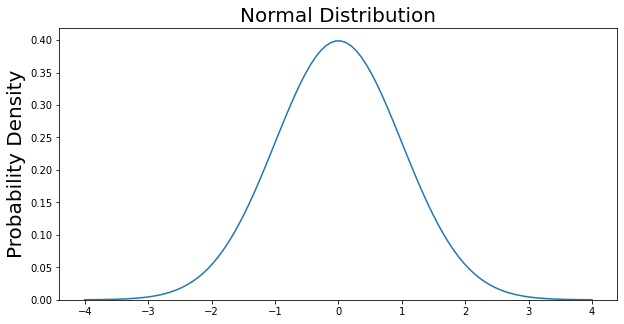

In [87]:

x = np.linspace(-4, 4, num = 100)
constant = 1.0 / np.sqrt(2*np.pi)
pdf_normal_distribution = constant * np.exp((-x**2) / 2.0)
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(x, pdf_normal_distribution);
ax.set_ylim(0);
ax.set_title('Normal Distribution', size = 20);
ax.set_ylabel('Probability Density', size = 20);

In [89]:

def normalProbabilityDensity(x):
    constant = 1.0 / np.sqrt(2*np.pi)
    return(constant * np.exp((-x**2) / 2.0) )
# Berechnung des Integrals um die kumulative Standardnormalverteilung zu berechnen, mit mü: 0 und Stdabw: 1

zoe_percentile, _ = quad(normalProbabilityDensity, np.NINF, 1.25)
mike_percentile, _ = quad(normalProbabilityDensity, np.NINF, 1.00)
print('Zoe: ', zoe_percentile)
print('Mike: ', mike_percentile)

In [502]:
M_Score_perc, _ = quad(normalProbabilityDensity, np.NINF, M_Score) #zweiter Wert ist nicht relevant - daher mit _ ausgegliedert
print("Es liegt eine Wahrscheinlichkeit für einen Betrug gem. Beneish-M-Score von ",M_Score_perc*100, " %", " vor.")
# http://eswf.uni-koeln.de/glossar/zvert.htm --> selbe Wert wie bei Tabelle - Berechnung ist korrekt

Es liegt eine Wahrscheinlichkeit für einen Betrug gem. Beneish-M-Score von  0.6392842494702098  %  vor.


################################################################################# Beneish-M abgeschlossen

# Wiley Kennzahlen Analyse S. 365ff (Page: 379ff)

### Jahr und Vorjahr

In [134]:
# jeweils einzelne Kennzahlen für jedes Jahr + Veränderung der Jahre jeweils darunter

current_ratio_J= AssetsCurrent_Jahr/LiabilitiesCurrent_Jahr
current_ratio_VJ= AssetsCurrent_Vorjahr/LiabilitiesCurrent_Vorjahr
change_current_ratio=current_ratio_J/current_ratio_VJ

quick_ratio_J= ( CashAndCashEquivalentsAtCarryingValue_Jahr + MarketableSecurities_Jahr + AccountsReceivableNetCurrent_Jahr) / LiabilitiesCurrent_Jahr
quick_ratio_VJ= ( CashAndCashEquivalentsAtCarryingValue_Vorjahr + MarketableSecurities_Vorjahr + AccountsReceivableNetCurrent_Vorjahr) / LiabilitiesCurrent_Vorjahr
change_quick_ratio=quick_ratio_J/quick_ratio_VJ

av_inventory_J=(InventoryNet_Jahr+(InventoryNet_Jahr - IncreaseDecreaseInInventories_Jahr))/2
av_inventory_VJ=(InventoryNet_Vorjahr+(InventoryNet_Vorjahr - IncreaseDecreaseInInventories_Vorjahr))/2
change_av_inventory=av_inventory_J/av_inventory_VJ

inventory_turnover_ratio_J=CostOfRevenue_Jahr/av_inventory_J
inventory_turnover_ratio_VJ=CostOfRevenue_Vorjahr/av_inventory_VJ
change_inv_ratio=inventory_turnover_ratio_J/inventory_turnover_ratio_VJ

av_receivable_J= AccountsReceivableNetCurrent_Jahr + (AccountsReceivableNetCurrent_Jahr - IncreaseDecreaseInAccountsReceivable_Jahr)
av_receivable_VJ = AccountsReceivableNetCurrent_Vorjahr + (AccountsReceivableNetCurrent_Vorjahr - IncreaseDecreaseInAccountsReceivable_Vorjahr)
change_av_receibales=av_receivable_J/av_receivable_VJ

receivable_turnover_J=Revenues_Jahr/av_receivable_J
receivable_turnover_VJ= Revenues_Vorjahr/av_receivable_VJ
change_rec_turnover=receivable_turnover_J/receivable_turnover_VJ

total_liabilities_J = LiabilitiesCurrent_Jahr + LiabilitiesNoncurrent_Jahr
total_liabilities_VJ = LiabilitiesCurrent_Vorjahr + LiabilitiesNoncurrent_Vorjahr

debt_equity_ratio_J = total_liabilities_J/ StockholdersEquity_Jahr
debt_equity_ratio_VJ = total_liabilities_VJ/ StockholdersEquity_Vorjahr
change_debt_equity_ratio = debt_equity_ratio_J/debt_equity_ratio_VJ

profit_margin_ratio_J = NetIncomeLoss_Jahr / Revenues_Jahr
profit_margin_ratio_VJ = NetIncomeLoss_Vorjahr / Revenues_Vorjahr
change_profit_margin_ratio = profit_margin_ratio_J/ profit_margin_ratio_VJ

### change_investing_CF muss noch hinzugefügt werden --> Ziel Veränderung Assets darstellen
## !!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!111
# change_investing_CF_J=

av_assets_J= (Assets_Jahr + (Assets_Vorjahr))/2
av_assets_VJ= (Assets_Vorjahr + (Assets_4))/2

asset_turnover_ratio_J = Revenues_Jahr / av_assets_J
asset_turnover_ratio_VJ = Revenues_Vorjahr / av_assets_VJ


### Vorjahr und Vor-Vorjahr

In [ ]:
# jeweils einzelne Kennzahlen für jedes Jahr + Veränderung der Jahre jeweils darunter

current_ratio_3= AssetsCurrent_3/LiabilitiesCurrent_3
current_ratio_4= AssetsCurrent_4/LiabilitiesCurrent_4
change_current_ratio_34=current_ratio_3/current_ratio_4

quick_ratio_3= ( CashAndCashEquivalentsAtCarryingValue_3 + MarketableSecurities_3 + AccountsReceivableNetCurrent_3) / LiabilitiesCurrent_3
quick_ratio_4= ( CashAndCashEquivalentsAtCarryingValue_4 + MarketableSecurities_4 + AccountsReceivableNetCurrent_4) / LiabilitiesCurrent_4
change_quick_ratio_34=quick_ratio_3/quick_ratio_4

av_inventory_3=(InventoryNet_3+(InventoryNet_3 - IncreaseDecreaseInInventories_3))/2
av_inventory_4=(InventoryNet_4+(InventoryNet_4 - IncreaseDecreaseInInventories_4))/2
change_av_inventory_34=av_inventory_3/av_inventory_4

inventory_turnover_ratio_3=CostOfRevenue_3/av_inventory_3
inventory_turnover_ratio_4=CostOfRevenue_4/av_inventory_4
change_inv_ratio_34=inventory_turnover_ratio_3/inventory_turnover_ratio_4

av_receivable_3= AccountsReceivableNetCurrent_3 + (AccountsReceivableNetCurrent_3 - IncreaseDecreaseInAccountsReceivable_3)
av_receivable_4 = AccountsReceivableNetCurrent_4 + (AccountsReceivableNetCurrent_4 - IncreaseDecreaseInAccountsReceivable_4)
change_av_receibales_34=av_receivable_3/av_receivable_4

receivable_turnover_3=Revenues_3/av_receivable_3
receivable_turnover_4= Revenues_4/av_receivable_4
change_rec_turnover_34=receivable_turnover_3/receivable_turnover_4

total_liabilities_3 = LiabilitiesCurrent_3 + LiabilitiesNoncurrent_3
total_liabilities_4 = LiabilitiesCurrent_4 + LiabilitiesNoncurrent_4

debt_equity_ratio_3 = total_liabilities_3/ StockholdersEquity_3
debt_equity_ratio_4 = total_liabilities_4/ StockholdersEquity_4
change_debt_equity_ratio_34 = debt_equity_ratio_3/debt_equity_ratio_4

profit_margin_ratio_3 = NetIncomeLoss_3 / Revenues_3
profit_margin_ratio_4 = NetIncomeLoss_4 / Revenues_4
change_profit_margin_ratio_34 = profit_margin_ratio_3/ profit_margin_ratio_4

### change_investing_CF muss noch hinzugefügt werden --> Ziel Veränderung Assets darstellen
## !!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!111
# change_investing_CF_3=

av_assets_3= (Assets_3 + Assets_4)/2
av_assets_4= Assets_4 # finde kein Lösung um Veränderung CF Investing hier zu berücksichtigen

asset_turnover_ratio_3 = Revenues_3 / av_assets_3
asset_turnover_ratio_4 = Revenues_4 / av_assets_4
